In [1]:
import gc
import gzip
import pandas as pd
import os
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression

try:
    from scipy.stats import norm
except ImportError:
    norm = None

In [2]:
file_path = r"CSV/Exports/Temp/11_keep_24h/merged_df.csv"
stroke_df = pd.read_csv(file_path)
stroke_df_tz8 = stroke_df[stroke_df["Time_Zone"] == 8].copy()

# Time to event

In [3]:
"""
Για την ομοιομορφία κρατάω τις εγγραφές των ασθενών που έχουν παραμονή περισσότερο τις μιας μέρας

Δεν θα είναι σωστό να συγκρίνω τις τιμές 24 ώρου για κάποιον που έχει καθίσει λιγότερες ώρες.
"""

stroke_df_tz8_los = stroke_df_tz8[stroke_df_tz8["los"] >= 1].copy()

# Duration στα events 30, 180, 360

In [4]:
df = stroke_df_tz8_los.copy()  # 1 row/stay, Time_Zone=8, LOS>=24h, sofa μέσα

# 1) Datetimes
df["icu_intime"] = pd.to_datetime(df["icu_intime"], errors="coerce")
df["dod"]        = pd.to_datetime(df["dod"], errors="coerce")

# 2) Time to death (days)
df["time_to_death_days"] = (df["dod"] - df["icu_intime"]).dt.total_seconds() / 86400.0

# Aν βρεθούν αρνητικά durations τα κάνω μηδέν
neg = df["time_to_death_days"].notna() & (df["time_to_death_days"] < 0)
if neg.any():
    print(f"Βρέθηκαν {neg.sum()} αρνητικά time_to_death_days. Θα τα κάνω 0.")
    df.loc[neg, "time_to_death_days"] = 0.0

# 3) duration + event για κάθε horizon
for H in [30, 180, 360]:
    mort_col = f"mort_{H}d"

    # event: από τα labels που έχω ήδη
    df[f"event_{H}d"] = pd.to_numeric(df[mort_col], errors="coerce").fillna(0).astype(int)

    # duration: αν υπάρχει dod -> min(ttd, H), αλλιώς censor στο H
    ttd = df["time_to_death_days"]
    df[f"duration_{H}d"] = np.where(
        ttd.notna(),
        np.minimum(ttd, float(H)),
        float(H)
    ).astype(float)

    # clamp για ασφάλεια
    df[f"duration_{H}d"] = df[f"duration_{H}d"].clip(lower=0, upper=float(H))

# 4) Quick summary
print("N:", len(df))
print("Deaths within 30d :", df["event_30d"].sum())
print("Deaths within 180d:", df["event_180d"].sum())
print("Deaths within 360d:", df["event_360d"].sum())

df[["time_to_death_days",
    "event_30d","duration_30d",
    "event_180d","duration_180d",
    "event_360d","duration_360d"
]].head(10)


Βρέθηκαν 6 αρνητικά time_to_death_days. Θα τα κάνω 0.
N: 3059
Deaths within 30d : 688
Deaths within 180d: 931
Deaths within 360d: 1041


,time_to_death_days,event_30d,duration_30d,event_180d,duration_180d,event_360d,duration_360d
7,NaN,0,30.000000,0,180.000000,0,360.000000
47,NaN,0,30.000000,0,180.000000,0,360.000000
55,NaN,0,30.000000,0,180.000000,0,360.000000
63,7.720833,1,7.720833,1,7.720833,1,7.720833
79,NaN,0,30.000000,0,180.000000,0,360.000000
87,NaN,0,30.000000,0,180.000000,0,360.000000
119,26.153877,1,26.153877,1,26.153877,1,26.153877
143,27.146238,1,27.146238,1,27.146238,1,27.146238
151,NaN,0,30.000000,0,180.000000,0,360.000000
159,10.903160,1,10.903160,1,10.903160,1,10.903160


In [5]:
def sanity_check_labels(df, H):
    mort_col = f"mort_{H}d"
    event_from_dod = ((df["time_to_death_days"].notna()) & (df["time_to_death_days"] <= H)).astype(int)
    mismatch = (df[mort_col].astype(int) != event_from_dod).sum()
    print(f"H={H}d mismatch mort_{H}d vs (dod<=H from icu_intime): {mismatch} / {len(df)}")
    if mismatch > 0:
        display(df.loc[df[mort_col].astype(int) != event_from_dod,
                       ["subject_id","hadm_id","stay_id","icu_intime","dod","time_to_death_days",mort_col]].head(10))

for H in [30,180,360]:
    sanity_check_labels(df, H)

H=30d mismatch mort_30d vs (dod<=H from icu_intime): 0 / 3059
H=180d mismatch mort_180d vs (dod<=H from icu_intime): 0 / 3059
H=360d mismatch mort_360d vs (dod<=H from icu_intime): 0 / 3059


# RDW

In [6]:
df = df.copy()

rdw_col = "RDW - Median"   # άλλαξέ το αν θες Mean
df["RDW_value"] = df[rdw_col]

# Quartiles (Q1–Q4)
df["RDW_q"] = pd.qcut(df["RDW_value"], 4, labels=["Q1","Q2","Q3","Q4"])

# quick check
print(df["RDW_q"].value_counts(dropna=False))
print("RDW missing:", df["RDW_value"].isna().mean())

RDW_q
Q1     802
Q2     756
Q3     739
Q4     733
NaN     29
Name: count, dtype: int64
RDW missing: 0.009480222294867604


# Kaplan–Meier curves

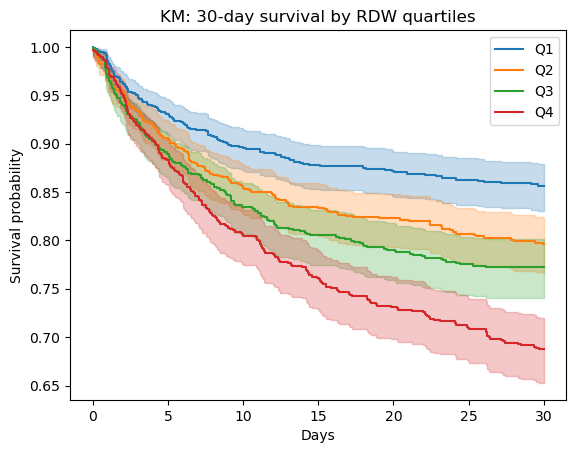

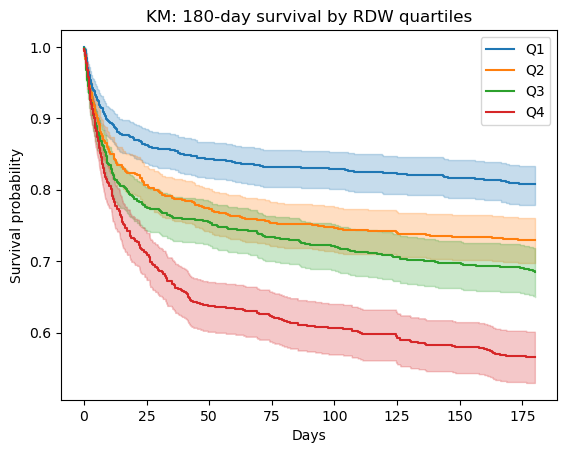

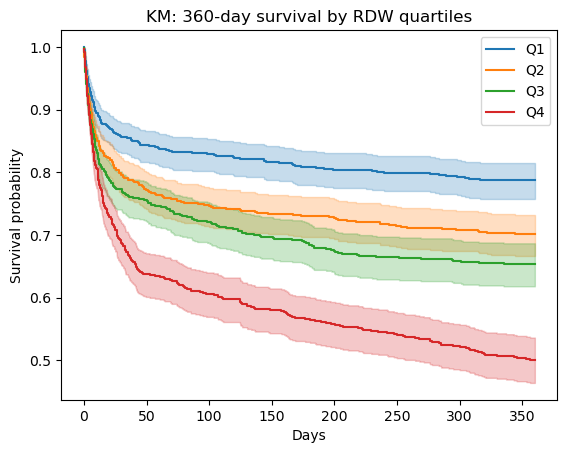

In [7]:
def km_by_quartile(df, H, group_col="RDW_q"):
    kmf = KaplanMeierFitter()
    ax = None

    duration_col = f"duration_{H}d"
    event_col    = f"event_{H}d"

    for q in ["Q1","Q2","Q3","Q4"]:
        mask = df[group_col] == q
        dfg = df.loc[mask, [duration_col, event_col]].dropna()
        kmf.fit(durations=dfg[duration_col], event_observed=dfg[event_col], label=q)
        ax = kmf.plot(ax=ax)

    ax.set_title(f"KM: {H}-day survival by RDW quartiles")
    ax.set_xlabel("Days")
    ax.set_ylabel("Survival probability")
    plt.show()

for H in [30, 180, 360]:
    km_by_quartile(df, H)


# Cox regression

In [8]:
import pandas as pd
from lifelines import CoxPHFitter

# gender -> numeric
df["gender_M"] = (df["gender"] == "M").astype(int)

# dummies
race_dummies  = pd.get_dummies(df["race"], prefix="race", drop_first=True)
rdw_q_dummies = pd.get_dummies(df["RDW_q"], prefix="RDWq", drop_first=True)  # Q1 reference

# Build one modeling table that contains all durations/events
base_cols = [
    "age", "gender_M",
    "sofa",
    "GCS - Median",
    "Non Invasive Blood Pressure mean (mmHg) - Median"
]

model_df = pd.concat(
    [
        df[[f"duration_{H}d" for H in [30,180,360]] + [f"event_{H}d" for H in [30,180,360]] + base_cols],
        race_dummies,
        rdw_q_dummies
    ],
    axis=1
)

rdw_q_cols = [c for c in model_df.columns if c.startswith("RDWq_")]
race_cols  = [c for c in model_df.columns if c.startswith("race_")]

model1_covs = ["age", "gender_M"] + race_cols + rdw_q_cols
model2_covs = model1_covs + ["sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

def fit_cox(model_df, H, covariates):
    duration_col = f"duration_{H}d"
    event_col    = f"event_{H}d"
    d = model_df[[duration_col, event_col] + covariates].dropna().copy()

    cph = CoxPHFitter()
    cph.fit(d, duration_col=duration_col, event_col=event_col)
    return cph, d

for H in [30, 180, 360]:
    print("\n" + "="*60)
    print(f"COX — Horizon: {H} days")

    cph1, d1 = fit_cox(model_df, H, model1_covs)
    print(f"Model 1 N used: {len(d1)} | events: {d1[f'event_{H}d'].sum()}")
    cph1.print_summary()

    cph2, d2 = fit_cox(model_df, H, model2_covs)
    print(f"\nModel 2 N used: {len(d2)} | events: {d2[f'event_{H}d'].sum()}")
    cph2.print_summary()



COX — Horizon: 30 days


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_30d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hig

Model 1 N used: 3059 | events: 688


<lifelines.CoxPHFitter: fitted with 3059 total observations, 2371 right-censored observations>
             duration col = 'duration_30d'
                event col = 'event_30d'
      baseline estimation = breslow
   number of observations = 3059
number of events observed = 688
   partial log-likelihood = -5322.40
         time fit was run = 2026-01-13 17:38:28 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
age                                             0.02      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                       -0.03      0.97      0.08           -0.19            0.12                0.83                1.12
race_ASIAN                                     15.66  6.31e+06   1109.04        -2158.03         2189.35                0.00                 inf
race_ASIAN - ASIAN INDIAN                       0.25      1.29   2125.46        -4165.58         4166.09                0.00                 inf
race_ASIAN - CHINESE                           15.40  4.88e+06   1109.04        -2158.29         2189.09                0.00                 inf
race_ASIAN - KOREAN                            15.59  5.87e+06   1109.05        -2158.10         2189.27                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                  16.06  9.39e+06   1109.04        -2157.63         2189.74                0.00                 inf
race_BLACK/AFRICAN                             15.57  5.75e+06   1109.05        -2158.12         2189.25                0.00                 inf
race_BLACK/AFRICAN AMERICAN                    15.03  3.36e+06   1109.04        -2158.66         2188.72                0.00                 inf
race_BLACK/CAPE VERDEAN                        14.78  2.62e+06   1109.05        -2158.91         2188.47                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                    14.64  2.28e+06   1109.05        -2159.05         2188.33                0.00                 inf
race_HISPANIC OR LATINO                        15.57  5.80e+06   1109.04        -2158.11         2189.26                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN        -0.02      0.98   3800.56        -7448.98         7448.94                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                0.09      1.09   2034.10        -3986.67         3986.85                0.00                 inf
race_HISPANIC/LATINO - CUBAN                   15.30  4.40e+06   1109.05        -2158.39         2188.99                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN               14.42  1.83e+06   1109.05        -2159.27         2188.11                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN              15.91  8.16e+06   1109.05        -2157.77         2189.60                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                -0.15      0.86   3800.56        -7449.10         7448.81                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                  0.96      2.61   3800.56        -7448.00         7449.92                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN            15.29  4.35e+06   1109.04        -2158.40         2188.97                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN               0.71      2.03   2202.55        -4316.21         4317.63                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                    0.19      1.21   2719.27        -5329.48         5329.86                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 15.25  4.18e+06   1109.05        -2158.44         2188.94                0.00                 inf
ra


Model 2 N used: 3025 | events: 670


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_30d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hig

<lifelines.CoxPHFitter: fitted with 3025 total observations, 2355 right-censored observations>
             duration col = 'duration_30d'
                event col = 'event_30d'
      baseline estimation = breslow
   number of observations = 3025
number of events observed = 670
   partial log-likelihood = -5021.17
         time fit was run = 2026-01-13 17:38:30 UTC

---
                                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                         
age                                               0.03      1.03      0.00            0.02            0.03                1.02                1.04
gender_M                                         -0.18      0.83      0.08           -0.34           -0.02                0.71                0.98
race_ASIAN                                       15.21  4.03e+06   1205.50        -2347.52         2377.94                0.00                 inf
race_ASIAN - ASIAN INDIAN                         0.14      1.15   2135.33        -4185.04         4185.31                0.00                 inf
race_ASIAN - CHINESE                             15.02  3.34e+06   1205.50        -2347.71         2377.75                0.00                 inf
race_ASIAN - KOREAN                              15.92  8.23e+06   1205.50        -2346.81         2378.65                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                    15.85  7.67e+06   1205.50        -2346.88         2378.58                0.00                 inf
race_BLACK/AFRICAN                               15.54  5.60e+06   1205.50        -2347.19         2378.27                0.00                 inf
race_BLACK/AFRICAN AMERICAN                      14.71  2.44e+06   1205.50        -2348.02         2377.44                0.00                 inf
race_BLACK/CAPE VERDEAN                          14.40  1.79e+06   1205.50        -2348.33         2377.13                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                      14.23  1.52e+06   1205.50        -2348.50         2376.96                0.00                 inf
race_HISPANIC OR LATINO                          15.01  3.30e+06   1205.50        -2347.72         2377.74                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN          -1.61      0.20   4138.98        -8113.87         8110.65                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                 -0.39      0.68   1815.32        -3558.36         3557.58                0.00                 inf
race_HISPANIC/LATINO - CUBAN                     15.10  3.62e+06   1205.50        -2347.63         2377.83                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN                 14.20  1.46e+06   1205.50        -2348.53         2376.93                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN                16.12  1.01e+07   1205.50        -2346.61         2378.85                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                  -0.10      0.91   4138.98        -8112.36         8112.16                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                    1.51      4.54   4138.98        -8110.75         8113.77                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN              14.93  3.04e+06   1205.50        -2347.80         2377.65                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN                 1.00      2.71   2334.03        -4573.61         4575.61                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                     -1.00      0.37   2994.05        -5869.24         5867.24                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   15.26  4.25e+06   1205.50        -2347.47         


COX — Horizon: 180 days
Model 1 N used: 3059 | events: 931


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_180d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3059 total observations, 2128 right-censored observations>
             duration col = 'duration_180d'
                event col = 'event_180d'
      baseline estimation = breslow
   number of observations = 3059
number of events observed = 931
   partial log-likelihood = -7168.75
         time fit was run = 2026-01-13 17:38:32 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
age                                             0.03      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                        0.04      1.04      0.07           -0.09            0.17                0.91                1.18
race_ASIAN                                     15.24  4.14e+06    806.62        -1565.71         1596.18                0.00                 inf
race_ASIAN - ASIAN INDIAN                       0.28      1.32   1554.81        -3047.09         3047.65                0.00                 inf
race_ASIAN - CHINESE                           15.15  3.79e+06    806.62        -1565.80         1596.09                0.00                 inf
race_ASIAN - KOREAN                            14.92  3.01e+06    806.62        -1566.03         1595.86                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                  15.43  5.04e+06    806.62        -1565.51         1596.38                0.00                 inf
race_BLACK/AFRICAN                             14.97  3.16e+06    806.62        -1565.98         1595.91                0.00                 inf
race_BLACK/AFRICAN AMERICAN                    14.70  2.43e+06    806.62        -1566.24         1595.65                0.00                 inf
race_BLACK/CAPE VERDEAN                        14.19  1.45e+06    806.62        -1566.76         1595.14                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                    14.44  1.87e+06    806.62        -1566.51         1595.39                0.00                 inf
race_HISPANIC OR LATINO                        14.95  3.12e+06    806.62        -1565.99         1595.90                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN        -0.15      0.86   2788.93        -5466.36         5466.06                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                0.07      1.08   1494.21        -2928.53         2928.68                0.00                 inf
race_HISPANIC/LATINO - CUBAN                   14.71  2.45e+06    806.62        -1566.24         1595.66                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN               14.07  1.29e+06    806.62        -1566.88         1595.02                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN              15.33  4.56e+06    806.62        -1565.62         1596.28                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                -0.22      0.80   2788.93        -5466.43         5465.99                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                  1.06      2.90   2788.93        -5465.15         5467.27                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN            14.98  3.20e+06    806.62        -1565.97         1595.93                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN               0.75      2.12   1620.92        -3176.20         3177.70                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                   15.29  4.37e+06    806.62        -1565.66         1596.24                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 14.57  2.14e+06    806.62        -1566.37         1595.52                0.00                 inf



Model 2 N used: 3025 | events: 913


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_180d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3025 total observations, 2112 right-censored observations>
             duration col = 'duration_180d'
                event col = 'event_180d'
      baseline estimation = breslow
   number of observations = 3025
number of events observed = 913
   partial log-likelihood = -6876.80
         time fit was run = 2026-01-13 17:38:34 UTC

---
                                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                         
age                                               0.03      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                         -0.09      0.92      0.07           -0.22            0.05                0.80                1.05
race_ASIAN                                       15.85  7.68e+06   1358.97        -2647.68         2679.39                0.00                 inf
race_ASIAN - ASIAN INDIAN                         0.25      1.29   2491.06        -4882.14         4882.64                0.00                 inf
race_ASIAN - CHINESE                             15.87  7.76e+06   1358.97        -2647.67         2679.40                0.00                 inf
race_ASIAN - KOREAN                              16.18  1.06e+07   1358.97        -2647.36         2679.72                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                    16.24  1.13e+07   1358.97        -2647.30         2679.78                0.00                 inf
race_BLACK/AFRICAN                               15.90  8.04e+06   1358.97        -2647.64         2679.44                0.00                 inf
race_BLACK/AFRICAN AMERICAN                      15.44  5.09e+06   1358.97        -2648.10         2678.98                0.00                 inf
race_BLACK/CAPE VERDEAN                          14.89  2.93e+06   1358.97        -2648.65         2678.43                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                      15.13  3.71e+06   1358.97        -2648.41         2678.67                0.00                 inf
race_HISPANIC OR LATINO                          15.46  5.19e+06   1358.97        -2648.08         2679.00                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN          -1.48      0.23   4681.27        -9176.60         9173.65                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                 -0.25      0.78   2149.50        -4213.19         4212.69                0.00                 inf
race_HISPANIC/LATINO - CUBAN                     15.58  5.83e+06   1358.97        -2647.96         2679.12                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN                 14.84  2.77e+06   1358.97        -2648.70         2678.37                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN                16.52  1.50e+07   1358.97        -2647.01         2680.06                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                  -0.13      0.88   4681.27        -9175.25         9174.99                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                    1.59      4.90   4681.27        -9173.53         9176.72                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN              15.65  6.29e+06   1358.97        -2647.88         2679.19                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN                 1.02      2.79   2662.26        -5216.91         5218.96                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                     15.44  5.06e+06   1358.97        -2648.10         2678.98                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   15.62  6.07e+06   1358.97        -2647.92       


COX — Horizon: 360 days
Model 1 N used: 3059 | events: 1041


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_360d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3059 total observations, 2018 right-censored observations>
             duration col = 'duration_360d'
                event col = 'event_360d'
      baseline estimation = breslow
   number of observations = 3059
number of events observed = 1041
   partial log-likelihood = -7986.07
         time fit was run = 2026-01-13 17:38:36 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
age                                             0.03      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                        0.05      1.05      0.06           -0.08            0.17                0.93                1.19
race_ASIAN                                     15.12  3.68e+06    747.13        -1449.23         1479.47                0.00                 inf
race_ASIAN - ASIAN INDIAN                       0.30      1.34   1449.06        -2839.81         2840.40                0.00                 inf
race_ASIAN - CHINESE                           15.04  3.39e+06    747.13        -1449.31         1479.39                0.00                 inf
race_ASIAN - KOREAN                            14.74  2.53e+06    747.13        -1449.61         1479.09                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                  15.30  4.41e+06    747.13        -1449.05         1479.65                0.00                 inf
race_BLACK/AFRICAN                             14.85  2.81e+06    747.13        -1449.50         1479.20                0.00                 inf
race_BLACK/AFRICAN AMERICAN                    14.76  2.57e+06    747.13        -1449.59         1479.11                0.00                 inf
race_BLACK/CAPE VERDEAN                        14.08  1.30e+06    747.13        -1450.27         1478.43                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                    14.33  1.67e+06    747.13        -1450.02         1478.68                0.00                 inf
race_HISPANIC OR LATINO                        14.82  2.73e+06    747.13        -1449.53         1479.17                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN        -0.19      0.83   2604.45        -5104.81         5104.44                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                0.09      1.09   1389.02        -2722.35         2722.52                0.00                 inf
race_HISPANIC/LATINO - CUBAN                   15.02  3.34e+06    747.13        -1449.33         1479.37                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN               13.93  1.12e+06    747.13        -1450.42         1478.28                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN              15.21  4.04e+06    747.13        -1449.14         1479.56                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                -0.21      0.81   2604.45        -5104.84         5104.41                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                  1.12      3.06   2604.45        -5103.50         5105.74                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN            15.09  3.57e+06    747.13        -1449.26         1479.44                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN               0.79      2.21   1502.96        -2944.96         2946.55                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                   15.27  4.29e+06    747.13        -1449.08         1479.62                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 14.42  1.84e+06    747.13        -1449.93         1478.77                0.00                 inf


Model 2 N used: 3025 | events: 1023


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_360d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3025 total observations, 2002 right-censored observations>
             duration col = 'duration_360d'
                event col = 'event_360d'
      baseline estimation = breslow
   number of observations = 3025
number of events observed = 1023
   partial log-likelihood = -7710.23
         time fit was run = 2026-01-13 17:38:38 UTC

---
                                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                         
age                                               0.03      1.03      0.00            0.02            0.03                1.02                1.04
gender_M                                         -0.06      0.94      0.06           -0.19            0.06                0.83                1.07
race_ASIAN                                       14.88  2.89e+06    788.14        -1529.85         1559.60                0.00                 inf
race_ASIAN - ASIAN INDIAN                         0.30      1.34   1465.21        -2871.47         2872.06                0.00                 inf
race_ASIAN - CHINESE                             14.89  2.94e+06    788.14        -1529.83         1559.62                0.00                 inf
race_ASIAN - KOREAN                              15.05  3.45e+06    788.14        -1529.67         1559.78                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                    15.19  3.96e+06    788.14        -1529.53         1559.92                0.00                 inf
race_BLACK/AFRICAN                               14.85  2.83e+06    788.14        -1529.87         1559.58                0.00                 inf
race_BLACK/AFRICAN AMERICAN                      14.63  2.25e+06    788.14        -1530.10         1559.35                0.00                 inf
race_BLACK/CAPE VERDEAN                          13.91  1.10e+06    788.14        -1530.82         1558.63                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                      14.16  1.41e+06    788.14        -1530.57         1558.88                0.00                 inf
race_HISPANIC OR LATINO                          14.47  1.92e+06    788.14        -1530.26         1559.19                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN          -1.37      0.25   2719.33        -5331.16         5328.41                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                 -0.18      0.84   1275.56        -2500.23         2499.87                0.00                 inf
race_HISPANIC/LATINO - CUBAN                     15.04  3.41e+06    788.14        -1529.68         1559.76                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN                 13.80  9.81e+05    788.14        -1530.93         1558.52                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN                15.47  5.23e+06    788.14        -1529.25         1560.19                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                  -0.12      0.89   2719.33        -5329.90         5329.66                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                    1.61      4.99   2719.33        -5328.18         5331.39                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN              14.89  2.93e+06    788.14        -1529.83         1559.61                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN                 1.05      2.85   1539.53        -3016.38         3018.47                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                     14.60  2.19e+06    788.14        -1530.13         1559.32                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   14.58  2.15e+06    788.14        -1530.15      

In [9]:
cph2.check_assumptions(d2, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3025 total observations, 2002 right-censored observations>
         test_name = proportional_hazard_test

---
                                                       test_statistic      p  -log2(p)
GCS - Median                                     km            123.98 <0.005     93.25
                                                 rank          123.99 <0.005     93.26
Non Invasive Blood Pressure mean (mmHg) - Median km              0.75   0.39      1.37
                                                 rank            0.75   0.39      1.37
RDWq_Q2                                          km              3.93   0.05      4.40
                                                 rank            3.93   0.05      4.40
RDWq_Q3                                          km              4.54   0.03      4.91
                                                 rank            4.54   0.03      4.91
RDWq_Q4                                          km             27.55 <0.005     22.64
                                                 rank           27.55 <0.005     22.64
age                                              km              5.13   0.02      5.41
                                                 rank            5.13   0.02      5.41
gender_M                                         km              8.90 <0.005      8.45
                                                 rank            8.89 <0.005      8.45
race_ASIAN                                       km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - ASIAN INDIAN                        km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - CHINESE                             km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - KOREAN                              km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - SOUTH EAST ASIAN                    km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/AFRICAN                               km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/AFRICAN AMERICAN                      km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/CAPE VERDEAN                          km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/CARIBBEAN ISLAND                      km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC OR LATINO                          km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - CENTRAL AMERICAN          km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - COLUMBIAN                 km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - CUBAN                     km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - DOMINICAN                 km              0.00   1.00      0.00
                                                 rank            0.



1. Variable 'age' failed the non-proportional test: p-value is 0.0235.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'gender_M' failed the non-proportional test: p-value is 0.0029.

   Advice: with so few unique values (only 2), you can include `strata=['gender_M', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'RDWq_Q2' failed the non-proportional test: p-value is 0.0473.

   Advice: with so few unique values (only 2), you can include `strata

[]

# Cox για 30/180/360 και πίνακας HR για RDW quartiles

In [10]:
for H in [30,180,360]:
    print(H, "events:", df[f"event_{H}d"].sum())

30 events: 688
180 events: 931
360 events: 1041


In [11]:
rdw_col = "RDW - Median"   # ή "RDW - Mean"

df = df.copy()
df["RDW_value"] = df[rdw_col]

# Quartiles με σταθερή σειρά (Q1 reference)
df["RDW_q"] = pd.qcut(df["RDW_value"], 4, labels=["Q1","Q2","Q3","Q4"])
df["RDW_q"] = df["RDW_q"].astype(pd.CategoricalDtype(categories=["Q1","Q2","Q3","Q4"], ordered=True))


In [12]:
# gender -> 0/1
df["gender_M"] = (df["gender"] == "M").astype(int)

# Race: κρατάμε top κατηγορίες, τα υπόλοιπα "Other" (για να μη γεμίσει dummies)
race_top = df["race"].value_counts().head(6).index  # 6 πιο συχνές
df["race_slim"] = np.where(df["race"].isin(race_top), df["race"], "Other")

race_dummies  = pd.get_dummies(df["race_slim"], prefix="race", drop_first=True)  # ref: πιο συχνή κατηγορία
rdw_dummies   = pd.get_dummies(df["RDW_q"], prefix="RDWq", drop_first=True)      # ref: Q1

# Core covariates
base_cols = ["age", "gender_M", "sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

# Modeling table (με durations/events για όλα τα horizons)
H_list = [30, 180, 360]
surv_cols = [f"duration_{H}d" for H in H_list] + [f"event_{H}d" for H in H_list]

model_df = pd.concat(
    [df[surv_cols + base_cols], race_dummies, rdw_dummies],
    axis=1
)


In [13]:
def fit_and_extract(model_df, H, covariates):
    duration_col = f"duration_{H}d"
    event_col    = f"event_{H}d"

    d = model_df[[duration_col, event_col] + covariates].dropna().copy()

    cph = CoxPHFitter()
    cph.fit(d, duration_col=duration_col, event_col=event_col)

    s = cph.summary.reset_index().copy()

    # robust: ονομάζω την πρώτη στήλη variable
    first_col = s.columns[0]
    s = s.rename(columns={first_col: "variable"})

    # CI cols robust (αν αλλάξουν ελαφρά τα names)
    ci_low_col  = [c for c in s.columns if "lower" in c and "exp(coef)" in c][0]
    ci_high_col = [c for c in s.columns if "upper" in c and "exp(coef)" in c][0]

    out = pd.DataFrame({
        "variable": s["variable"].astype(str),
        "HR": s["exp(coef)"].astype(float),
        "CI_low": s[ci_low_col].astype(float),
        "CI_high": s[ci_high_col].astype(float),
        "p": s["p"].astype(float),
        "H": H,
        "N_used": len(d),
        "events_used": int(d[event_col].sum())
    })

    return cph, out


# Covariate lists
rdw_q_cols = [c for c in model_df.columns if c.startswith("RDWq_")]   # RDWq_Q2, RDWq_Q3, RDWq_Q4
race_cols  = [c for c in model_df.columns if c.startswith("race_")]

model1_covs = ["age","gender_M"] + race_cols + rdw_q_cols
model2_covs = model1_covs + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

all_results = []

for H in [30, 180, 360]:
    cph1, res1 = fit_and_extract(model_df, H, model1_covs)
    res1["model"] = "Model1"

    cph2, res2 = fit_and_extract(model_df, H, model2_covs)
    res2["model"] = "Model2"

    all_results.append(res1)
    all_results.append(res2)

results_df = pd.concat(all_results, ignore_index=True)

rdw_results = results_df[results_df["variable"].str.startswith("RDWq_")].copy()


# αλλάζω τα ονόματα στην variable
name_map = {
    "RDWq_Q2": "RDW Q2 vs Q1",
    "RDWq_Q3": "RDW Q3 vs Q1",
    "RDWq_Q4": "RDW Q4 vs Q1",
}
rdw_results["variable"] = rdw_results["variable"].replace(name_map)

# Στρογγυλοποίηση
for c in ["HR","CI_low","CI_high"]:
    rdw_results[c] = rdw_results[c].astype(float).round(3)
rdw_results["p"] = rdw_results["p"].astype(float).map(lambda x: f"{x:.3g}")

# Ταξινόμηση
rdw_results = rdw_results.sort_values(["H","model","variable"]).reset_index(drop=True)

rdw_results


,variable,HR,CI_low,CI_high,p,H,N_used,events_used,model
0,RDW Q2 vs Q1,1.169,0.928,1.472,0.186,30,3059,688,Model1
1,RDW Q3 vs Q1,1.249,0.994,1.569,0.056,30,3059,688,Model1
2,RDW Q4 vs Q1,1.785,1.440,2.213,1.26e-07,30,3059,688,Model1
3,RDW Q2 vs Q1,1.023,0.808,1.295,0.85,30,3025,670,Model2
4,RDW Q3 vs Q1,1.009,0.799,1.275,0.939,30,3025,670,Model2
5,RDW Q4 vs Q1,1.467,1.172,1.837,0.00083,30,3025,670,Model2
6,RDW Q2 vs Q1,1.221,0.998,1.495,0.0525,180,3059,931,Model1
7,RDW Q3 vs Q1,1.348,1.106,1.644,0.00309,180,3059,931,Model1
8,RDW Q4 vs Q1,2.044,1.695,2.464,6.55e-14,180,3059,931,Model1
9,RDW Q2 vs Q1,1.098,0.894,1.349,0.372,180,3025,913,Model2


In [14]:
# Φτιάχνω στήλη "HR (95% CI)"
t = rdw_results.copy()
t["HR (95% CI)"] = t.apply(lambda r: f'{r["HR"]:.3f} ({r["CI_low"]:.3f}–{r["CI_high"]:.3f})', axis=1)

# Pivot: γραμμές = (H, model), στήλες = (Q2/Q3/Q4)
table = (
    t.pivot_table(
        index=["H","model"],
        columns="variable",
        values=["HR (95% CI)","p"],
        aggfunc="first"
    )
)

# flatten columns
table.columns = [f"{a} | {b}" for a,b in table.columns]
table = table.reset_index().sort_values(["H","model"])

table


,H,model,HR (95% CI) | RDW Q2 vs Q1,HR (95% CI) | RDW Q3 vs Q1,HR (95% CI) | RDW Q4 vs Q1,p | RDW Q2 vs Q1,p | RDW Q3 vs Q1,p | RDW Q4 vs Q1
0,30,Model1,1.169 (0.928–1.472),1.249 (0.994–1.569),1.785 (1.440–2.213),0.186,0.056,1.26e-07
1,30,Model2,1.023 (0.808–1.295),1.009 (0.799–1.275),1.467 (1.172–1.837),0.85,0.939,0.00083
2,180,Model1,1.221 (0.998–1.495),1.348 (1.106–1.644),2.044 (1.695–2.464),0.0525,0.00309,6.55e-14
3,180,Model2,1.098 (0.894–1.349),1.125 (0.919–1.378),1.730 (1.425–2.102),0.372,0.253,3.3e-08
4,360,Model1,1.236 (1.019–1.498),1.356 (1.123–1.638),2.185 (1.830–2.607),0.0313,0.00158,4.96e-18
5,360,Model2,1.124 (0.924–1.367),1.156 (0.953–1.402),1.883 (1.566–2.263),0.242,0.141,1.56e-11


# AUC

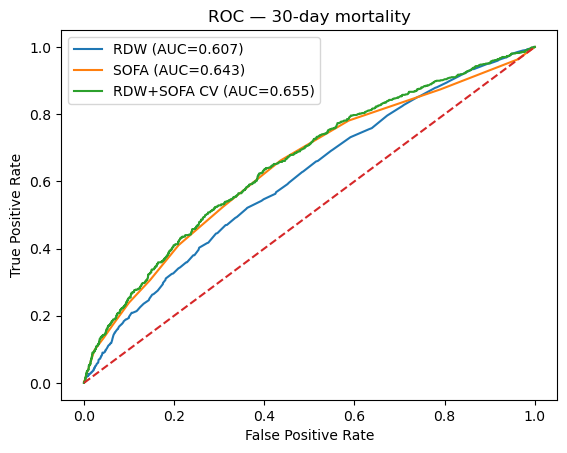

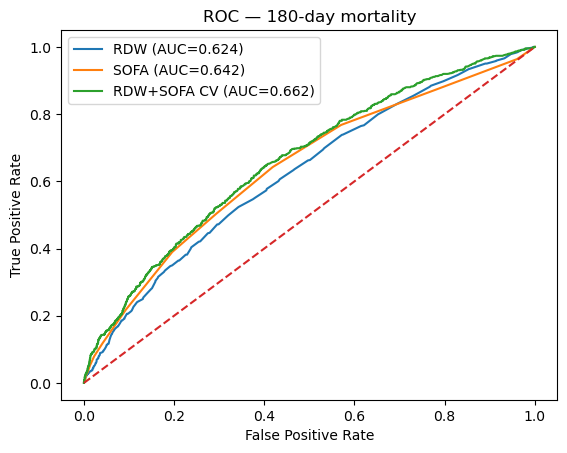

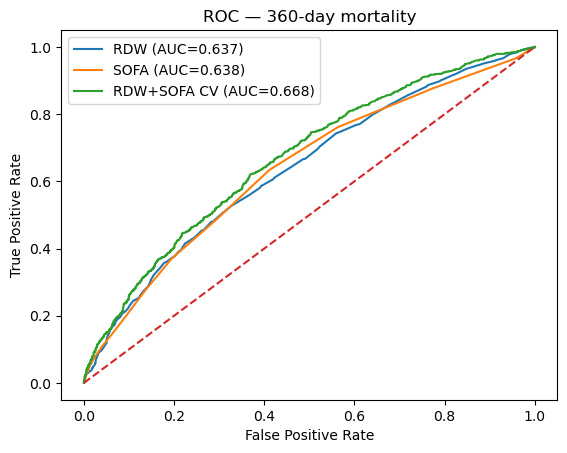

,H,N_used,events,AUC_RDW,CI_RDW_low,CI_RDW_high,AUC_SOFA,CI_SOFA_low,CI_SOFA_high,AUC_RDW+SOFA_CV,CI_combo_low,CI_combo_high
0,30,3030,666,0.607,0.583,0.630,0.643,0.619,0.668,0.655,0.631,0.678
1,180,3030,909,0.624,0.603,0.644,0.642,0.621,0.663,0.662,0.642,0.683
2,360,3030,1018,0.637,0.616,0.658,0.638,0.617,0.658,0.668,0.647,0.688


In [15]:
# --- Ρύθμιση predictors ---

rdw_col = "RDW - Median"   # ή "RDW - Mean"

assert rdw_col in df.columns
assert "sofa" in df.columns

# ------------------------------------------------------------
# Bootstrap CI για AUC (stratified bootstrap για σταθερότητα)
# ------------------------------------------------------------
def auc_bootstrap_ci(y_true, y_score, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    idx0 = np.where(y_true == 0)[0]
    idx1 = np.where(y_true == 1)[0]

    aucs = []
    for _ in range(n_boot):
        b0 = rng.choice(idx0, size=len(idx0), replace=True)
        b1 = rng.choice(idx1, size=len(idx1), replace=True)
        b = np.concatenate([b0, b1])
        aucs.append(roc_auc_score(y_true[b], y_score[b]))

    aucs = np.array(aucs)
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return float(lo), float(hi)

# ------------------------------------------------------------
# AUC computation per horizon
# ------------------------------------------------------------
def compute_auc_for_horizon(df, H, rdw_col, n_boot=2000, seed=42, make_plots=False):
    y_col = f"mort_{H}d"

    # Κοινό δείγμα για δίκαιη σύγκριση RDW vs SOFA vs RDW+SOFA:
    sub = df[[y_col, rdw_col, "sofa"]].dropna().copy()

    y = sub[y_col].astype(int).values
    rdw_score = sub[rdw_col].astype(float).values
    sofa_score = sub["sofa"].astype(float).values

    # RDW-only AUC
    auc_rdw = roc_auc_score(y, rdw_score)
    ci_rdw = auc_bootstrap_ci(y, rdw_score, n_boot=n_boot, seed=seed)

    # SOFA-only AUC
    auc_sofa = roc_auc_score(y, sofa_score)
    ci_sofa = auc_bootstrap_ci(y, sofa_score, n_boot=n_boot, seed=seed+1)

    # RDW + SOFA (LogReg) με CV προβλέψεις (out-of-fold probabilities)
    X = sub[[rdw_col, "sofa"]].values
    lr = LogisticRegression(max_iter=2000, solver="lbfgs")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    p_cv = cross_val_predict(lr, X, y, cv=cv, method="predict_proba")[:, 1]

    auc_combo = roc_auc_score(y, p_cv)
    ci_combo = auc_bootstrap_ci(y, p_cv, n_boot=n_boot, seed=seed+2)

    out = {
        "H": H,
        "N_used": len(sub),
        "events": int(y.sum()),
        "AUC_RDW": auc_rdw, "CI_RDW_low": ci_rdw[0], "CI_RDW_high": ci_rdw[1],
        "AUC_SOFA": auc_sofa, "CI_SOFA_low": ci_sofa[0], "CI_SOFA_high": ci_sofa[1],
        "AUC_RDW+SOFA_CV": auc_combo, "CI_combo_low": ci_combo[0], "CI_combo_high": ci_combo[1],
    }

    # ROC curves
    if make_plots:
        import matplotlib.pyplot as plt

        def plot_roc(y_true, score, label):
            fpr, tpr, _ = roc_curve(y_true, score)
            plt.plot(fpr, tpr, label=label)

        plt.figure()
        plot_roc(y, rdw_score,  f"RDW (AUC={auc_rdw:.3f})")
        plot_roc(y, sofa_score, f"SOFA (AUC={auc_sofa:.3f})")
        plot_roc(y, p_cv,       f"RDW+SOFA CV (AUC={auc_combo:.3f})")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.title(f"ROC — {H}-day mortality")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    return out

# Run for 30/180/360
rows = []
for H in [30, 180, 360]:
    rows.append(compute_auc_for_horizon(df, H, rdw_col, n_boot=2000, seed=42, make_plots=True))

auc_df = pd.DataFrame(rows)

# πιο ωραίο formatting
for c in [c for c in auc_df.columns if c.startswith("AUC_") or c.startswith("CI_")]:
    auc_df[c] = auc_df[c].astype(float).round(3)

auc_df


# DeLong test

In [16]:
# -----------------------------
# DeLong implementation
# -----------------------------
def _compute_midrank(x):
    """Computes midranks for a 1D array x."""
    x = np.asarray(x)
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        # ranks are 1..N
        mid = 0.5 * (i + j - 1) + 1
        T[i:j] = mid
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2

def _fast_delong(predictions_sorted_transposed, label_1_count):
    """
    Fast DeLong for AUC covariance.
    predictions_sorted_transposed: shape (n_classifiers, n_examples) with examples sorted: positives first.
    """
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m

    pos = predictions_sorted_transposed[:, :m]
    neg = predictions_sorted_transposed[:, m:]

    k = predictions_sorted_transposed.shape[0]
    tx = np.zeros((k, m), dtype=float)
    ty = np.zeros((k, n), dtype=float)
    tz = np.zeros((k, m + n), dtype=float)

    for r in range(k):
        tz[r, :] = _compute_midrank(predictions_sorted_transposed[r, :])
        tx[r, :] = _compute_midrank(pos[r, :])
        ty[r, :] = _compute_midrank(neg[r, :])

    aucs = (tz[:, :m].sum(axis=1) - m * (m + 1) / 2.0) / (m * n)

    v01 = (tz[:, :m] - tx) / n
    v10 = 1.0 - (tz[:, m:] - ty) / m

    sx = np.cov(v01)
    sy = np.cov(v10)
    delong_cov = sx / m + sy / n
    return aucs, delong_cov

def delong_roc_test(y_true, pred1, pred2):
    """
    Returns: auc1, auc2, auc_diff, p_value (two-sided), z
    """
    y_true = np.asarray(y_true).astype(int)
    pred1 = np.asarray(pred1).astype(float)
    pred2 = np.asarray(pred2).astype(float)

    # sort so that positives (1) are first
    order = np.argsort(y_true)[::-1]
    y_sorted = y_true[order]
    m = int(y_sorted.sum())
    if m == 0 or m == len(y_sorted):
        raise ValueError("Need both positive and negative samples for DeLong test.")

    preds = np.vstack([pred1, pred2])[:, order]
    aucs, cov = _fast_delong(preds, m)

    auc1, auc2 = float(aucs[0]), float(aucs[1])
    diff = auc1 - auc2
    var_diff = float(cov[0, 0] + cov[1, 1] - 2 * cov[0, 1])

    if var_diff <= 0:
        # numerical edge case
        z = np.nan
        p = np.nan
    else:
        z = diff / np.sqrt(var_diff)
        if norm is not None:
            p = 2 * norm.sf(abs(z))
        else:
            # fallback (approx) if scipy not available
            from math import erf, sqrt
            p = 2 * (1 - 0.5 * (1 + erf(abs(z) / sqrt(2))))

    return auc1, auc2, diff, float(p), float(z)

# -----------------------------
# Run DeLong for each horizon
# -----------------------------
rdw_col = "RDW - Median"   # άλλαξέ το αν χρησιμοποιείς Mean
seed = 42

def get_scores_for_horizon(df, H, rdw_col, seed=42):
    y_col = f"mort_{H}d"
    sub = df[[y_col, rdw_col, "sofa"]].dropna().copy()

    y = sub[y_col].astype(int).values
    rdw_score = sub[rdw_col].astype(float).values
    sofa_score = sub["sofa"].astype(float).values

    # RDW+SOFA score via out-of-fold probabilities (5-fold CV)
    X = sub[[rdw_col, "sofa"]].values
    lr = LogisticRegression(max_iter=2000, solver="lbfgs")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    p_cv = cross_val_predict(lr, X, y, cv=cv, method="predict_proba")[:, 1]

    return sub, y, rdw_score, sofa_score, p_cv

rows = []
for H in [30, 180, 360]:
    sub, y, rdw_score, sofa_score, combo_score = get_scores_for_horizon(df, H, rdw_col, seed=seed)

    # DeLong comparisons
    a1, a2, d, p, z = delong_roc_test(y, combo_score, sofa_score)  # combo vs sofa
    rows.append({"H": H, "comparison": "RDW+SOFA (CV) vs SOFA", "AUC_1": a1, "AUC_2": a2, "AUC_diff": d, "p_value": p, "z": z, "N": len(sub), "events": int(y.sum())})

    a1, a2, d, p, z = delong_roc_test(y, sofa_score, rdw_score)   # sofa vs rdw
    rows.append({"H": H, "comparison": "SOFA vs RDW", "AUC_1": a1, "AUC_2": a2, "AUC_diff": d, "p_value": p, "z": z, "N": len(sub), "events": int(y.sum())})

    a1, a2, d, p, z = delong_roc_test(y, combo_score, rdw_score)  # combo vs rdw
    rows.append({"H": H, "comparison": "RDW+SOFA (CV) vs RDW", "AUC_1": a1, "AUC_2": a2, "AUC_diff": d, "p_value": p, "z": z, "N": len(sub), "events": int(y.sum())})

delong_df = pd.DataFrame(rows)
delong_df[["AUC_1","AUC_2","AUC_diff"]] = delong_df[["AUC_1","AUC_2","AUC_diff"]].round(4)
delong_df["p_value"] = delong_df["p_value"].map(lambda x: f"{x:.3g}")
delong_df


,H,comparison,AUC_1,AUC_2,AUC_diff,p_value,z,N,events
0,30,RDW+SOFA (CV) vs SOFA,0.6553,0.6431,0.0122,0.0204,2.318384,3030,666
1,30,SOFA vs RDW,0.6431,0.6074,0.0358,0.0176,2.373979,3030,666
2,30,RDW+SOFA (CV) vs RDW,0.6553,0.6074,0.0480,1.81e-05,4.287488,3030,666
3,180,RDW+SOFA (CV) vs SOFA,0.6620,0.6415,0.0205,0.000499,3.481302,3030,909
4,180,SOFA vs RDW,0.6415,0.6241,0.0175,0.199,1.283168,3030,909
5,180,RDW+SOFA (CV) vs RDW,0.6620,0.6241,0.0380,2.6e-05,4.205977,3030,909
6,360,RDW+SOFA (CV) vs SOFA,0.6680,0.6375,0.0305,6.57e-06,4.507244,3030,1018
7,360,SOFA vs RDW,0.6375,0.6370,0.0005,0.969,0.038253,3030,1018
8,360,RDW+SOFA (CV) vs RDW,0.6680,0.6370,0.0310,6.36e-05,3.999156,3030,1018


# Youden index

In [17]:
from sklearn.metrics import roc_curve

def youden_cutoff(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    # drop inf threshold if exists
    mask = np.isfinite(thr)
    fpr, tpr, thr = fpr[mask], tpr[mask], thr[mask]

    j = tpr - fpr
    ix = int(np.argmax(j))
    return {
        "cutoff": float(thr[ix]),
        "sensitivity": float(tpr[ix]),
        "specificity": float(1 - fpr[ix]),
        "youden_J": float(j[ix])
    }
rows = []
for H in [30, 180, 360]:
    sub, y, rdw_score, sofa_score, combo_score = get_scores_for_horizon(df, H, rdw_col, seed=seed)

    r = youden_cutoff(y, rdw_score)
    rows.append({"H": H, "score": "RDW", **r})

    r = youden_cutoff(y, sofa_score)
    rows.append({"H": H, "score": "SOFA", **r})

    r = youden_cutoff(y, combo_score)
    rows.append({"H": H, "score": "RDW+SOFA (CV prob)", **r})

youden_df = pd.DataFrame(rows)
youden_df[["cutoff","sensitivity","specificity","youden_J"]] = youden_df[["cutoff","sensitivity","specificity","youden_J"]].round(3)
youden_df

,H,score,cutoff,sensitivity,specificity,youden_J
0,30,RDW,14.350,0.521,0.638,0.159
1,30,SOFA,4.000,0.662,0.564,0.226
2,30,RDW+SOFA (CV prob),0.199,0.635,0.601,0.236
3,180,RDW,14.400,0.521,0.660,0.181
4,180,SOFA,4.000,0.642,0.581,0.224
5,180,RDW+SOFA (CV prob),0.268,0.651,0.594,0.245
6,360,RDW,14.400,0.528,0.672,0.200
7,360,SOFA,4.000,0.634,0.589,0.223
8,360,RDW+SOFA (CV prob),0.312,0.620,0.631,0.251


# Albumin

In [19]:
# ---------------------------
# Albumin quartiles + RAR
# ---------------------------

alb_col = "Albumin  - Median"   # ή "Albumin - Mean" κλπ
rdw_col = "RDW - Median"       # να ταιριάζει με αυτό που ήδη χρησιμοποιείς

assert alb_col in df.columns, f"Missing column: {alb_col}"
assert rdw_col in df.columns, f"Missing column: {rdw_col}"

df["Albumin_value"] = pd.to_numeric(df[alb_col], errors="coerce")
df["RDW_value"]     = pd.to_numeric(df[rdw_col], errors="coerce")

print("Albumin missing:", df["Albumin_value"].isna().mean())
print("RDW missing:", df["RDW_value"].isna().mean())

# Quartiles Albumin (Q1=χαμηλότερο, Q4=υψηλότερο) — οι NaN μένουν NaN
df["Alb_q"] = pd.qcut(df["Albumin_value"], 4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
df["Alb_q"] = df["Alb_q"].astype(pd.CategoricalDtype(categories=["Q1","Q2","Q3","Q4"], ordered=True))

print(df["Alb_q"].value_counts(dropna=False))

# RAR = RDW / Albumin (όπως στο paper)
df["RAR"] = np.where(
    df["RDW_value"].notna() & df["Albumin_value"].notna() & (df["Albumin_value"] != 0),
    df["RDW_value"] / df["Albumin_value"],
    np.nan
)

print("RAR missing:", df["RAR"].isna().mean())

df["RAR_q"] = pd.qcut(df["RAR"], 4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
df["RAR_q"] = df["RAR_q"].astype(pd.CategoricalDtype(categories=["Q1","Q2","Q3","Q4"], ordered=True))

print(df["RAR_q"].value_counts(dropna=False))

Albumin missing: 0.6031382804838182
RDW missing: 0.009480222294867604
Alb_q
NaN    1845
Q1      324
Q2      318
Q3      291
Q4      281
Name: count, dtype: int64
RAR missing: 0.603792088917947
RAR_q
NaN    1847
Q1      305
Q3      303
Q4      303
Q2      301
Name: count, dtype: int64


In [33]:
# ---------------------------
# COX with Albumin quartiles (Q4 reference) + explicit Missing category
# ---------------------------

df2 = df.copy()
df2["gender_M"] = (df2["gender"] == "M").astype(int)

# Race slim
race_top = df2["race"].value_counts().head(6).index
df2["race_slim"] = np.where(df2["race"].isin(race_top), df2["race"], "Other")
race_dummies = pd.get_dummies(df2["race_slim"], prefix="race", drop_first=True)

# ---------------------------
# Albumin quartiles: add Missing and set Q4 as reference
# ---------------------------
# (αν Alb_q δεν είναι categorical, κάν' το)
if not pd.api.types.is_categorical_dtype(df2["Alb_q"]):
    df2["Alb_q"] = df2["Alb_q"].astype(
        pd.CategoricalDtype(categories=["Q1", "Q2", "Q3", "Q4"], ordered=True)
    )

df2["Alb_q2"] = df2["Alb_q"].cat.add_categories(["Missing"]).fillna("Missing")

alb_all = pd.get_dummies(df2["Alb_q2"], prefix="ALBq", drop_first=False)

# reference = πραγματικό Q4
if "ALBq_Q4" in alb_all.columns:
    alb_dummies = alb_all.drop(columns=["ALBq_Q4"])
else:
    # fallback (σπάνιο): αν δεν υπάρχει Q4, χρησιμοποίησε drop_first=True
    alb_dummies = pd.get_dummies(df2["Alb_q2"], prefix="ALBq", drop_first=True)

# ---------------------------
# Build model dataframe
# ---------------------------
base_cols = ["age", "gender_M", "sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]
H_list = [30, 180, 360]
surv_cols = [f"duration_{H}d" for H in H_list] + [f"event_{H}d" for H in H_list]

model_df_alb = pd.concat([df2[surv_cols + base_cols], race_dummies, alb_dummies], axis=1)

alb_q_cols = [c for c in model_df_alb.columns if c.startswith("ALBq_")]
race_cols  = [c for c in model_df_alb.columns if c.startswith("race_")]

model1_covs = ["age","gender_M"] + race_cols + alb_q_cols
model2_covs = model1_covs + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

# ---------------------------
# Fit models
# ---------------------------
all_results = []
for H in [30, 180, 360]:
    cph1, res1 = fit_and_extract(model_df_alb, H, model1_covs)
    res1["model"] = "Model1"

    cph2, res2 = fit_and_extract(model_df_alb, H, model2_covs)
    res2["model"] = "Model2"

    all_results += [res1, res2]

results_alb_df = pd.concat(all_results, ignore_index=True)

alb_results = results_alb_df[results_alb_df["variable"].str.startswith("ALBq_")].copy()

# rename (προαιρετικά: πρόσθεσε και Missing)
name_map_alb = {
    "ALBq_Q1": "Albumin Q1 vs Q4",
    "ALBq_Q2": "Albumin Q2 vs Q4",
    "ALBq_Q3": "Albumin Q3 vs Q4",
    "ALBq_Missing": "Albumin Missing vs Q4",
}
alb_results["variable"] = alb_results["variable"].replace(name_map_alb)

for c in ["HR","CI_low","CI_high"]:
    alb_results[c] = alb_results[c].astype(float).round(3)
alb_results["p"] = alb_results["p"].astype(float).map(lambda x: f"{x:.3g}")

alb_results = alb_results.sort_values(["H","model","variable"]).reset_index(drop=True)
alb_results


C:\Users\Dimopoulos\AppData\Local\Temp\ipykernel_120\3401971045.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df2["Alb_q"]):


,variable,HR,CI_low,CI_high,p,H,N_used,events_used,model
0,Albumin Missing vs Q4,0.883,0.661,1.181,0.403,30,3059,688,Model1
1,Albumin Q1 vs Q4,1.790,1.287,2.490,0.000543,30,3059,688,Model1
2,Albumin Q2 vs Q4,1.824,1.316,2.529,0.000312,30,3059,688,Model1
3,Albumin Q3 vs Q4,1.375,0.964,1.962,0.0787,30,3059,688,Model1
4,Albumin Missing vs Q4,0.824,0.613,1.107,0.199,30,3025,670,Model2
5,Albumin Q1 vs Q4,1.002,0.707,1.419,0.992,30,3025,670,Model2
6,Albumin Q2 vs Q4,1.275,0.912,1.781,0.155,30,3025,670,Model2
7,Albumin Q3 vs Q4,1.087,0.760,1.556,0.648,30,3025,670,Model2
8,Albumin Missing vs Q4,0.915,0.709,1.182,0.497,180,3059,931,Model1
9,Albumin Q1 vs Q4,2.071,1.554,2.759,6.64e-07,180,3059,931,Model1


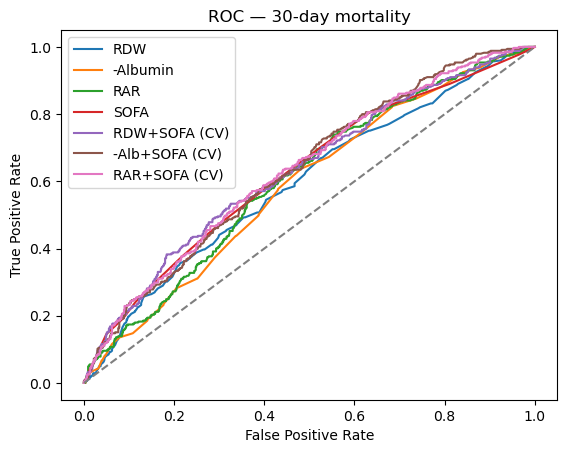

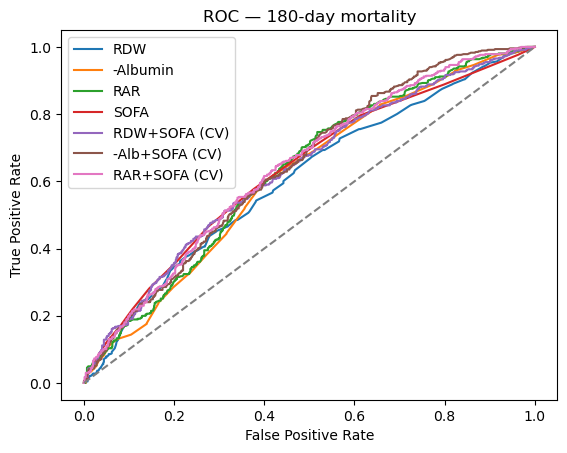

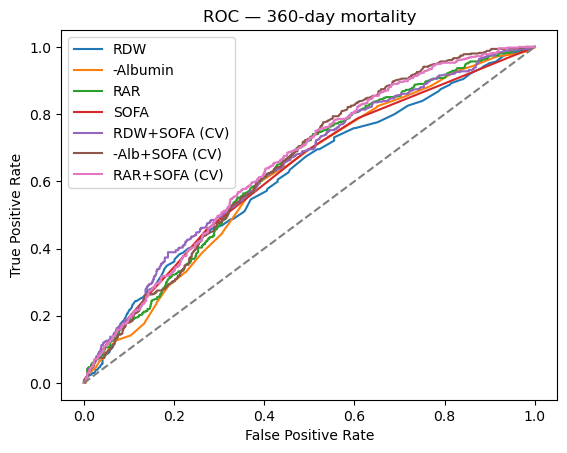

,H,N_used,events,AUC_RDW,CI_RDW_low,CI_RDW_high,AUC_-Albumin,CI_-Alb_low,CI_-Alb_high,AUC_RAR,...,CI_SOFA_high,AUC_RDW+SOFA_CV,CI_RDW+SOFA_low,CI_RDW+SOFA_high,AUC_-Alb+SOFA_CV,CI_-Alb+SOFA_low,CI_-Alb+SOFA_high,AUC_RAR+SOFA_CV,CI_RAR+SOFA_low,CI_RAR+SOFA_high
0,30,1212,345,0.595,0.561,0.631,0.588,0.552,0.623,0.605,...,0.661,0.632,0.595,0.666,0.634,0.601,0.667,0.635,0.600,0.669
1,180,1212,466,0.607,0.576,0.640,0.614,0.582,0.647,0.629,...,0.664,0.633,0.601,0.666,0.642,0.612,0.673,0.642,0.611,0.674
2,360,1212,509,0.618,0.586,0.649,0.619,0.587,0.650,0.637,...,0.660,0.645,0.613,0.678,0.651,0.620,0.681,0.655,0.624,0.686


In [23]:
# ----------------------------
# AUC per horizon: RDW vs Albumin vs RAR (+SOFA combos)
# ----------------------------

def compute_auc_bundle(df, H, rdw_col, alb_col, n_boot=2000, seed=42, make_plots=False):
    y_col = f"mort_{H}d"

    # φτιάχνω τα scores
    tmp = df[[y_col, rdw_col, alb_col, "sofa", "RAR"]].copy()
    tmp[rdw_col] = pd.to_numeric(tmp[rdw_col], errors="coerce")
    tmp[alb_col] = pd.to_numeric(tmp[alb_col], errors="coerce")
    tmp["sofa"]  = pd.to_numeric(tmp["sofa"], errors="coerce")

    # κοινό δείγμα για FAIR σύγκριση ΟΛΩΝ (RDW, Albumin, RAR, SOFA, combos)
    sub = tmp.dropna(subset=[y_col, rdw_col, alb_col, "sofa", "RAR"]).copy()

    y = sub[y_col].astype(int).values
    rdw_score = sub[rdw_col].astype(float).values
    alb_score = (-sub[alb_col].astype(float).values)   # -Albumin => higher = worse
    rar_score = sub["RAR"].astype(float).values
    sofa_score = sub["sofa"].astype(float).values

    out = {"H": H, "N_used": len(sub), "events": int(y.sum())}

    # single-marker AUCs
    out["AUC_RDW"] = roc_auc_score(y, rdw_score)
    out["CI_RDW_low"], out["CI_RDW_high"] = auc_bootstrap_ci(y, rdw_score, n_boot=n_boot, seed=seed)

    out["AUC_-Albumin"] = roc_auc_score(y, alb_score)
    out["CI_-Alb_low"], out["CI_-Alb_high"] = auc_bootstrap_ci(y, alb_score, n_boot=n_boot, seed=seed+1)

    out["AUC_RAR"] = roc_auc_score(y, rar_score)
    out["CI_RAR_low"], out["CI_RAR_high"] = auc_bootstrap_ci(y, rar_score, n_boot=n_boot, seed=seed+2)

    out["AUC_SOFA"] = roc_auc_score(y, sofa_score)
    out["CI_SOFA_low"], out["CI_SOFA_high"] = auc_bootstrap_ci(y, sofa_score, n_boot=n_boot, seed=seed+3)

    # combos via LR CV probs
    def cv_auc(X):
        lr = LogisticRegression(max_iter=2000, solver="lbfgs")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        p = cross_val_predict(lr, X, y, cv=cv, method="predict_proba")[:, 1]
        return roc_auc_score(y, p), p

    auc_rdw_sofa, p_rdw_sofa = cv_auc(sub[[rdw_col, "sofa"]].values)
    out["AUC_RDW+SOFA_CV"] = auc_rdw_sofa
    out["CI_RDW+SOFA_low"], out["CI_RDW+SOFA_high"] = auc_bootstrap_ci(y, p_rdw_sofa, n_boot=n_boot, seed=seed+10)

    auc_alb_sofa, p_alb_sofa = cv_auc(np.column_stack([alb_score, sofa_score]))
    out["AUC_-Alb+SOFA_CV"] = auc_alb_sofa
    out["CI_-Alb+SOFA_low"], out["CI_-Alb+SOFA_high"] = auc_bootstrap_ci(y, p_alb_sofa, n_boot=n_boot, seed=seed+11)

    auc_rar_sofa, p_rar_sofa = cv_auc(np.column_stack([rar_score, sofa_score]))
    out["AUC_RAR+SOFA_CV"] = auc_rar_sofa
    out["CI_RAR+SOFA_low"], out["CI_RAR+SOFA_high"] = auc_bootstrap_ci(y, p_rar_sofa, n_boot=n_boot, seed=seed+12)

    if make_plots:
        plt.figure()
        for label, score in [
            ("RDW", rdw_score),
            ("-Albumin", alb_score),
            ("RAR", rar_score),
            ("SOFA", sofa_score),
            ("RDW+SOFA (CV)", p_rdw_sofa),
            ("-Alb+SOFA (CV)", p_alb_sofa),
            ("RAR+SOFA (CV)", p_rar_sofa),
        ]:
            fpr, tpr, _ = roc_curve(y, score)
            plt.plot(fpr, tpr, label=f"{label}")
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"ROC — {H}-day mortality")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    return out, (sub, y, rdw_score, alb_score, rar_score, sofa_score, p_rdw_sofa, p_alb_sofa, p_rar_sofa)

rows = []
cache = {}  # για να reuse στα DeLong/Youden
for H in [30, 180, 360]:
    out, pack = compute_auc_bundle(df, H, rdw_col=rdw_col, alb_col=alb_col, n_boot=2000, seed=42, make_plots=True)
    rows.append(out)
    cache[H] = pack

auc_bundle_df = pd.DataFrame(rows)

# formatting
for c in auc_bundle_df.columns:
    if c.startswith("AUC_") or c.startswith("CI_"):
        auc_bundle_df[c] = auc_bundle_df[c].astype(float).round(3)

auc_bundle_df

In [24]:
# -----------------------------
# DeLong tests per horizon
# -----------------------------

rows = []
for H in [30, 180, 360]:
    sub, y, rdw_s, alb_s, rar_s, sofa_s, p_rdw_sofa, p_alb_sofa, p_rar_sofa = cache[H]

    # single vs single
    a1,a2,d,p,z = delong_roc_test(y, rdw_s, alb_s)
    rows.append({"H":H, "comparison":"RDW vs -Albumin", "AUC_1":a1, "AUC_2":a2, "AUC_diff":d, "p_value":p, "z":z, "N":len(sub), "events":int(y.sum())})

    a1,a2,d,p,z = delong_roc_test(y, rar_s, rdw_s)
    rows.append({"H":H, "comparison":"RAR vs RDW", "AUC_1":a1, "AUC_2":a2, "AUC_diff":d, "p_value":p, "z":z, "N":len(sub), "events":int(y.sum())})

    a1,a2,d,p,z = delong_roc_test(y, rar_s, alb_s)
    rows.append({"H":H, "comparison":"RAR vs -Albumin", "AUC_1":a1, "AUC_2":a2, "AUC_diff":d, "p_value":p, "z":z, "N":len(sub), "events":int(y.sum())})

    # combos vs sofa
    a1,a2,d,p,z = delong_roc_test(y, p_rar_sofa, sofa_s)
    rows.append({"H":H, "comparison":"RAR+SOFA (CV) vs SOFA", "AUC_1":a1, "AUC_2":a2, "AUC_diff":d, "p_value":p, "z":z, "N":len(sub), "events":int(y.sum())})

    a1,a2,d,p,z = delong_roc_test(y, p_rdw_sofa, sofa_s)
    rows.append({"H":H, "comparison":"RDW+SOFA (CV) vs SOFA", "AUC_1":a1, "AUC_2":a2, "AUC_diff":d, "p_value":p, "z":z, "N":len(sub), "events":int(y.sum())})

    a1,a2,d,p,z = delong_roc_test(y, p_alb_sofa, sofa_s)
    rows.append({"H":H, "comparison":"-Alb+SOFA (CV) vs SOFA", "AUC_1":a1, "AUC_2":a2, "AUC_diff":d, "p_value":p, "z":z, "N":len(sub), "events":int(y.sum())})

delong_bundle_df = pd.DataFrame(rows)
delong_bundle_df[["AUC_1","AUC_2","AUC_diff"]] = delong_bundle_df[["AUC_1","AUC_2","AUC_diff"]].round(4)
delong_bundle_df["p_value"] = delong_bundle_df["p_value"].map(lambda x: f"{x:.3g}")
delong_bundle_df

,H,comparison,AUC_1,AUC_2,AUC_diff,p_value,z,N,events
0,30,RDW vs -Albumin,0.5950,0.5881,0.0070,0.738,0.334149,1212,345
1,30,RAR vs RDW,0.6053,0.5950,0.0102,0.474,0.716317,1212,345
2,30,RAR vs -Albumin,0.6053,0.5881,0.0172,0.0358,2.099533,1212,345
3,30,RAR+SOFA (CV) vs SOFA,0.6349,0.6256,0.0093,0.124,1.536182,1212,345
4,30,RDW+SOFA (CV) vs SOFA,0.6318,0.6256,0.0062,0.4,0.842170,1212,345
5,30,-Alb+SOFA (CV) vs SOFA,0.6343,0.6256,0.0088,0.154,1.425331,1212,345
6,180,RDW vs -Albumin,0.6066,0.6140,-0.0073,0.707,-0.376202,1212,466
7,180,RAR vs RDW,0.6287,0.6066,0.0220,0.103,1.631155,1212,466
8,180,RAR vs -Albumin,0.6287,0.6140,0.0147,0.0519,1.943852,1212,466
9,180,RAR+SOFA (CV) vs SOFA,0.6424,0.6322,0.0101,0.184,1.328594,1212,466


In [25]:
# -----------------------------
# Youden cutoffs
# -----------------------------

rows = []
for H in [30, 180, 360]:
    sub, y, rdw_s, alb_s, rar_s, sofa_s, p_rdw_sofa, p_alb_sofa, p_rar_sofa = cache[H]

    for name, score in [
        ("RDW", rdw_s),
        ("-Albumin", alb_s),
        ("RAR", rar_s),
        ("SOFA", sofa_s),
        ("RDW+SOFA (CV)", p_rdw_sofa),
        ("-Alb+SOFA (CV)", p_alb_sofa),
        ("RAR+SOFA (CV)", p_rar_sofa),
    ]:
        r = youden_cutoff(y, score)
        rows.append({"H": H, "score": name, **r})

youden_bundle_df = pd.DataFrame(rows)
youden_bundle_df[["cutoff","sensitivity","specificity","youden_J"]] = youden_bundle_df[["cutoff","sensitivity","specificity","youden_J"]].round(3)
youden_bundle_df


,H,score,cutoff,sensitivity,specificity,youden_J
0,30,RDW,13.900,0.696,0.449,0.144
1,30,-Albumin,-3.400,0.641,0.516,0.156
2,30,RAR,3.970,0.739,0.448,0.187
3,30,SOFA,4.000,0.701,0.475,0.177
4,30,RDW+SOFA (CV),0.289,0.533,0.675,0.208
5,30,-Alb+SOFA (CV),0.241,0.725,0.472,0.196
6,30,RAR+SOFA (CV),0.274,0.571,0.627,0.198
7,180,RDW,13.950,0.672,0.496,0.168
8,180,-Albumin,-3.350,0.594,0.605,0.199
9,180,RAR,3.970,0.747,0.483,0.229


# Test

In [26]:
rdw_col = "RDW - Median"

tmp = df.copy()
tmp[rdw_col] = pd.to_numeric(tmp[rdw_col], errors="coerce")

display(
    tmp.groupby("RDW_q")
       .agg(N=("RDW_q","size"),
            RDW_median=(rdw_col,"median"),
            RDW_mean=(rdw_col,"mean"),
            mort30=("mort_30d","mean"),
            mort180=("mort_180d","mean"),
            mort360=("mort_360d","mean"))
)


C:\Users\Dimopoulos\AppData\Local\Temp\ipykernel_120\1885480331.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("RDW_q")


,N,RDW_median,RDW_mean,mort30,mort180,mort360
RDW_q,,,,,,
Q1,802,12.9,12.834663,0.143392,0.192020,0.211970
Q2,756,13.7,13.685516,0.203704,0.269841,0.298942
Q3,739,14.5,14.522530,0.227334,0.315291,0.346414
Q4,733,16.2,16.878035,0.312415,0.433834,0.499318


In [27]:
H = 30
print(df[[f"event_{H}d", f"mort_{H}d"]].head(10))
print("event mean:", df[f"event_{H}d"].mean())
print("mort mean :", df[f"mort_{H}d"].mean())


     event_30d  mort_30d
7            0         0
47           0         0
55           0         0
63           1         1
79           0         0
87           0         0
119          1         1
143          1         1
151          0         0
159          1         1
event mean: 0.22491010134030728
mort mean : 0.22491010134030728


In [29]:
for H in [30, 180, 360]:
    dur = f"duration_{H}d"
    ev  = f"event_{H}d"
    tmp = df.dropna(subset=["RDW_q", dur, ev]).copy()

    bad = tmp[(tmp[ev].astype(int)==1) & (tmp[dur].astype(float) > H)]
    print(f"H={H}: N={len(tmp)}, bad(event=1 & duration>H)={len(bad)}")

H=30: N=3030, bad(event=1 & duration>H)=0
H=180: N=3030, bad(event=1 & duration>H)=0
H=360: N=3030, bad(event=1 & duration>H)=0


In [30]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def km_debug(df, H):
    dur = f"duration_{H}d"
    ev  = f"event_{H}d"

    tmp = df.dropna(subset=["RDW_q", dur, ev]).copy()
    tmp[ev] = tmp[ev].astype(int)
    tmp[dur] = tmp[dur].astype(float)

    kmf = KaplanMeierFitter()
    for q in ["Q1","Q2","Q3","Q4"]:
        g = tmp[tmp["RDW_q"] == q]
        if g.empty:
            continue
        kmf.fit(g[dur], event_observed=g[ev], label=q)
        S_H = float(kmf.survival_function_at_times(H).iloc[0])
        mort = float(g[ev].mean())
        print(f"H={H} {q}: N={len(g)} mort={mort:.3f} 1-mort={1-mort:.3f}  KM_S(H)={S_H:.3f}")

for H in [30,180,360]:
    km_debug(df, H)


H=30 Q1: N=802 mort=0.143 1-mort=0.857  KM_S(H)=0.857
H=30 Q2: N=756 mort=0.204 1-mort=0.796  KM_S(H)=0.796
H=30 Q3: N=739 mort=0.227 1-mort=0.773  KM_S(H)=0.773
H=30 Q4: N=733 mort=0.312 1-mort=0.688  KM_S(H)=0.688
H=180 Q1: N=802 mort=0.192 1-mort=0.808  KM_S(H)=0.808
H=180 Q2: N=756 mort=0.270 1-mort=0.730  KM_S(H)=0.730
H=180 Q3: N=739 mort=0.315 1-mort=0.685  KM_S(H)=0.685
H=180 Q4: N=733 mort=0.434 1-mort=0.566  KM_S(H)=0.566
H=360 Q1: N=802 mort=0.212 1-mort=0.788  KM_S(H)=0.788
H=360 Q2: N=756 mort=0.299 1-mort=0.701  KM_S(H)=0.701
H=360 Q3: N=739 mort=0.346 1-mort=0.654  KM_S(H)=0.654
H=360 Q4: N=733 mort=0.499 1-mort=0.501  KM_S(H)=0.501


In [31]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def km_by_quartile_fixed(df, H, group_col):
    dur = f"duration_{H}d"

    # προτίμησε event_{H}d, αλλιώς mort_{H}d
    if f"event_{H}d" in df.columns:
        ev = f"event_{H}d"
    elif f"mort_{H}d" in df.columns:
        ev = f"mort_{H}d"
    else:
        raise KeyError(f"Δεν βρήκα ούτε event_{H}d ούτε mort_{H}d")

    tmp = df.dropna(subset=[group_col, dur, ev]).copy()
    tmp[dur] = pd.to_numeric(tmp[dur], errors="coerce")
    tmp[ev]  = pd.to_numeric(tmp[ev], errors="coerce").astype(int)

    # (προαιρετικό) κόψε durations > H για να είναι καθαρό horizon plot
    tmp[dur] = tmp[dur].clip(lower=0, upper=H)

    # enforce σειρά Q1->Q4 αν είναι quartiles
    if set(tmp[group_col].astype(str).unique()) >= {"Q1","Q2","Q3","Q4"}:
        tmp[group_col] = tmp[group_col].astype(
            pd.CategoricalDtype(categories=["Q1","Q2","Q3","Q4"], ordered=True)
        )

    kmf = KaplanMeierFitter()

    plt.figure(figsize=(7,5))
    for q, g in tmp.groupby(group_col, sort=False):
        label = str(q)

        kmf.fit(g[dur], event_observed=g[ev], label=label)
        kmf.plot_survival_function(ci_show=True)

        # sanity: S(H) πρέπει ~ 1 - mort_mean
        S_H = float(kmf.survival_function_at_times(H).iloc[0])
        mort = float(g[ev].mean())
        print(f"H={H} {label}: N={len(g)} mort={mort:.3f} KM_S(H)={S_H:.3f}")

    plt.title(f"KM: {H}-day survival by {group_col}")
    plt.xlabel("Days")
    plt.ylabel("Survival probability")
    plt.grid(True, alpha=0.2)
    plt.legend(title=None)
    plt.show()


C:\Users\Dimopoulos\AppData\Local\Temp\ipykernel_120\1684419935.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, g in tmp.groupby(group_col, sort=False):


H=30 Q4: N=733 mort=0.312 KM_S(H)=0.688
H=30 Q3: N=739 mort=0.227 KM_S(H)=0.773
H=30 Q1: N=802 mort=0.143 KM_S(H)=0.857
H=30 Q2: N=756 mort=0.204 KM_S(H)=0.796


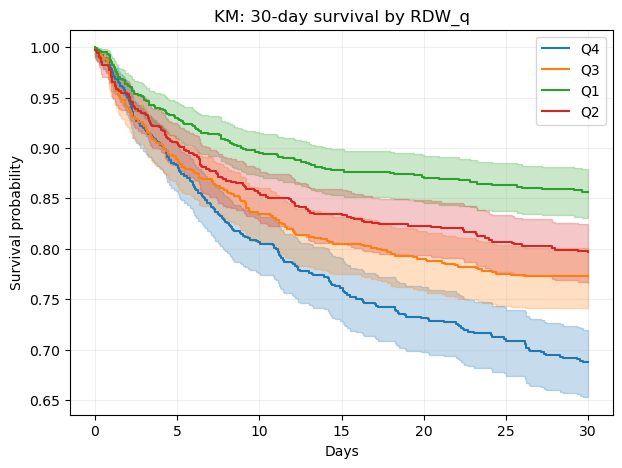

C:\Users\Dimopoulos\AppData\Local\Temp\ipykernel_120\1684419935.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, g in tmp.groupby(group_col, sort=False):


H=180 Q4: N=733 mort=0.434 KM_S(H)=0.566
H=180 Q3: N=739 mort=0.315 KM_S(H)=0.685
H=180 Q1: N=802 mort=0.192 KM_S(H)=0.808
H=180 Q2: N=756 mort=0.270 KM_S(H)=0.730


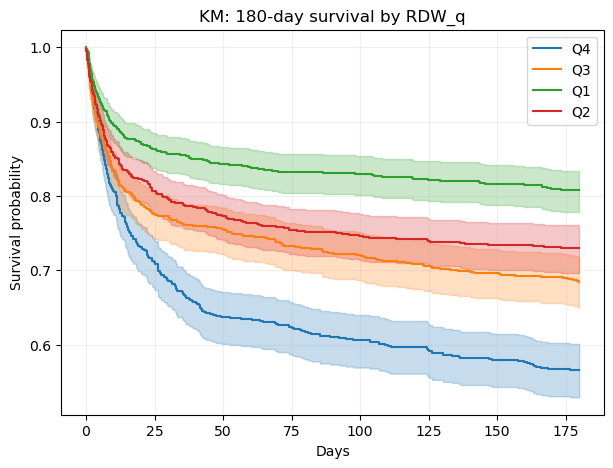

C:\Users\Dimopoulos\AppData\Local\Temp\ipykernel_120\1684419935.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, g in tmp.groupby(group_col, sort=False):


H=360 Q4: N=733 mort=0.499 KM_S(H)=0.501
H=360 Q3: N=739 mort=0.346 KM_S(H)=0.654
H=360 Q1: N=802 mort=0.212 KM_S(H)=0.788
H=360 Q2: N=756 mort=0.299 KM_S(H)=0.701


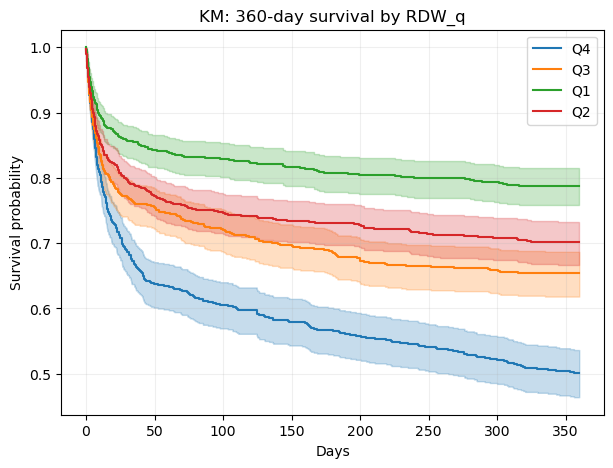

In [32]:
for H in [30, 180, 360]:
    km_by_quartile_fixed(df.dropna(subset=["RDW_q"]), H, group_col="RDW_q")


In [37]:
model_df_alb.isna().mean().sort_values(ascending=False).head(15)

Non Invasive Blood Pressure mean (mmHg) - Median    0.011115
race_HISPANIC OR LATINO                             0.000000
ALBq_Q3                                             0.000000
ALBq_Q2                                             0.000000
ALBq_Q1                                             0.000000
race_WHITE                                          0.000000
race_UNKNOWN                                        0.000000
race_UNABLE TO OBTAIN                               0.000000
race_Other                                          0.000000
race_OTHER                                          0.000000
duration_30d                                        0.000000
duration_180d                                       0.000000
GCS - Median                                        0.000000
sofa                                                0.000000
gender_M                                            0.000000
dtype: float64

In [38]:
cols_model2 = [f"duration_{H}d" for H in [30,180,360]] + [f"event_{H}d" for H in [30,180,360]] \
              + ["age","gender_M"] + race_cols + alb_q_cols \
              + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

model_df_alb[cols_model2].isna().any(axis=1).sum()

np.int64(34)

# Cox για RAR (continuous + quartiles) με HRs

In [39]:
import numpy as np
import pandas as pd

# ---------------------------
# COX with RAR: continuous + quartiles (Q4 ref) + Missing category
# ---------------------------

df = df.copy()
df["gender_M"] = (df["gender"] == "M").astype(int)

# (προαιρετικό) καθάρισε race casing για να μην έχεις race_Other και race_OTHER μαζί
df["race"] = df["race"].astype(str)

# Race slim
race_top = df["race"].value_counts().head(6).index
df["race_slim"] = np.where(df["race"].isin(race_top), df["race"], "Other")
race_dummies = pd.get_dummies(df["race_slim"], prefix="race", drop_first=True)
race_cols = list(race_dummies.columns)

# Ensure RAR exists + numeric
df["RAR"] = pd.to_numeric(df.get("RAR", np.nan), errors="coerce")

# Continuous standardization (HR per 1 SD)
rar_mean = df["RAR"].mean(skipna=True)
rar_std  = df["RAR"].std(skipna=True)
df["RAR_z"] = (df["RAR"] - rar_mean) / rar_std

# Quartiles on observed RAR only (NaN stays NaN)
df["RAR_q"] = pd.qcut(df["RAR"], 4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
df["RAR_q"] = df["RAR_q"].astype(pd.CategoricalDtype(categories=["Q1","Q2","Q3","Q4"], ordered=True))

# Add Missing category for quartiles
df2 = df.copy()
df2["RAR_q2"] = df2["RAR_q"].cat.add_categories(["Missing"]).fillna("Missing")

rar_all = pd.get_dummies(df2["RAR_q2"], prefix="RARq", drop_first=False)
# reference = Q4 (true Q4, όχι Missing)
if "RARq_Q4" in rar_all.columns:
    rar_dummies = rar_all.drop(columns=["RARq_Q4"])
else:
    rar_dummies = pd.get_dummies(df2["RAR_q2"], prefix="RARq", drop_first=True)

rar_q_cols = list(rar_dummies.columns)

# Base covariates (ίδια με πριν)
base_cols = ["age", "gender_M", "sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]
H_list = [30, 180, 360]
surv_cols = [f"duration_{H}d" for H in H_list] + [f"event_{H}d" for H in H_list]

# Build one big model df that contains everything we may use
model_df_rar = pd.concat(
    [
        df2[surv_cols + base_cols + ["RAR", "RAR_z"]],
        race_dummies,
        rar_dummies
    ],
    axis=1
)

# --- Define cov sets ---
# Continuous (per 1 unit)
model1_cont_unit = ["age","gender_M"] + race_cols + ["RAR"]
model2_cont_unit = model1_cont_unit + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

# Continuous (per 1 SD)
model1_cont_sd = ["age","gender_M"] + race_cols + ["RAR_z"]
model2_cont_sd = model1_cont_sd + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

# Quartiles (+ Missing) with Q4 reference
model1_q = ["age","gender_M"] + race_cols + rar_q_cols
model2_q = model1_q + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

all_results = []

for H in H_list:
    # ---- Continuous: per 1 unit ----
    cph, res = fit_and_extract(model_df_rar, H, model1_cont_unit)
    res["model"] = "Model1"; res["spec"] = "RAR continuous (per 1 unit)"
    all_results.append(res)

    cph, res = fit_and_extract(model_df_rar, H, model2_cont_unit)
    res["model"] = "Model2"; res["spec"] = "RAR continuous (per 1 unit)"
    all_results.append(res)

    # ---- Continuous: per 1 SD ----
    cph, res = fit_and_extract(model_df_rar, H, model1_cont_sd)
    res["model"] = "Model1"; res["spec"] = "RAR continuous (per 1 SD)"
    all_results.append(res)

    cph, res = fit_and_extract(model_df_rar, H, model2_cont_sd)
    res["model"] = "Model2"; res["spec"] = "RAR continuous (per 1 SD)"
    all_results.append(res)

    # ---- Quartiles (+ Missing) ----
    cph, res = fit_and_extract(model_df_rar, H, model1_q)
    res["model"] = "Model1"; res["spec"] = "RAR quartiles (Q4 ref + Missing)"
    all_results.append(res)

    cph, res = fit_and_extract(model_df_rar, H, model2_q)
    res["model"] = "Model2"; res["spec"] = "RAR quartiles (Q4 ref + Missing)"
    all_results.append(res)

results_rar_df = pd.concat(all_results, ignore_index=True)

# Keep only exposure terms (RAR / RAR_z / RARq_*), and make friendly labels
rar_only = results_rar_df[
    results_rar_df["variable"].isin(["RAR","RAR_z"]) |
    results_rar_df["variable"].str.startswith("RARq_")
].copy()

name_map = {
    "RAR": "RAR (per 1 unit)",
    "RAR_z": "RAR (per 1 SD)",
    "RARq_Q1": "RAR Q1 vs Q4",
    "RARq_Q2": "RAR Q2 vs Q4",
    "RARq_Q3": "RAR Q3 vs Q4",
    "RARq_Missing": "RAR Missing vs Q4",
}
rar_only["variable"] = rar_only["variable"].replace(name_map)

for c in ["HR","CI_low","CI_high"]:
    rar_only[c] = rar_only[c].astype(float).round(3)
rar_only["p"] = rar_only["p"].astype(float).map(lambda x: f"{x:.3g}")

rar_only = rar_only.sort_values(["spec","H","model","variable"]).reset_index(drop=True)
rar_only


,variable,HR,CI_low,CI_high,p,H,N_used,events_used,model,spec
0,RAR (per 1 SD),1.268,1.160,1.386,1.76e-07,30,1212,345,Model1,RAR continuous (per 1 SD)
1,RAR (per 1 SD),1.114,1.002,1.238,0.0455,30,1203,339,Model2,RAR continuous (per 1 SD)
2,RAR (per 1 SD),1.289,1.195,1.391,4.66e-11,180,1212,466,Model1,RAR continuous (per 1 SD)
3,RAR (per 1 SD),1.156,1.057,1.264,0.00153,180,1203,460,Model2,RAR continuous (per 1 SD)
4,RAR (per 1 SD),1.298,1.207,1.395,1.5e-12,360,1212,509,Model1,RAR continuous (per 1 SD)
5,RAR (per 1 SD),1.175,1.079,1.279,0.000208,360,1203,503,Model2,RAR continuous (per 1 SD)
6,RAR (per 1 unit),1.177,1.107,1.251,1.76e-07,30,1212,345,Model1,RAR continuous (per 1 unit)
7,RAR (per 1 unit),1.077,1.001,1.158,0.0455,30,1203,339,Model2,RAR continuous (per 1 unit)
8,RAR (per 1 unit),1.191,1.130,1.254,4.66e-11,180,1212,466,Model1,RAR continuous (per 1 unit)
9,RAR (per 1 unit),1.104,1.039,1.174,0.00153,180,1203,460,Model2,RAR continuous (per 1 unit)


# Restricted cubic splines (RCS) για dose–response

RCS knots: [3.07717105 3.86486486 4.75782658 7.47971014]
H=30: failed with penalizer=0.0 -> singular/collinear
H=30: OK with penalizer=0.0001 | N=1212 | events=345 | p=14
H=30: failed with penalizer=0.0 -> singular/collinear


C:\ProgramData\anaconda3\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.13585e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


H=30: OK with penalizer=0.0001 | N=1203 | events=339 | p=17

H=30d
Model1 spline penalizer=0.0001 | non-linearity LR=7.216, df=5, p=0.205 | N=1212, events=345
Model2 spline penalizer=0.0001 | non-linearity LR=2.822, df=5, p=0.727 | N=1203, events=339


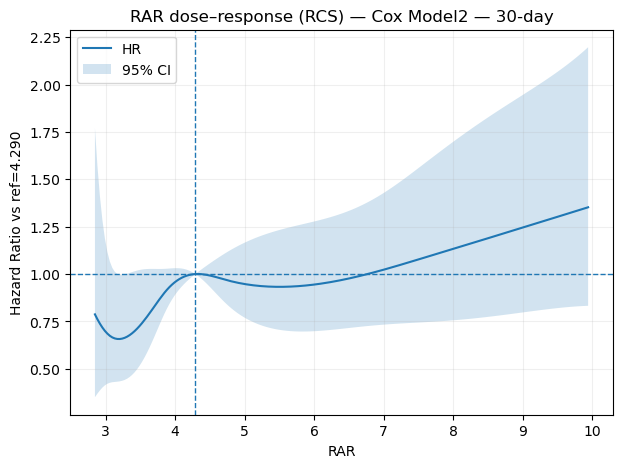

H=180: failed with penalizer=0.0 -> singular/collinear
H=180: OK with penalizer=0.0001 | N=1212 | events=466 | p=14


C:\ProgramData\anaconda3\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.15528e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33761e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.6232e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


H=180: OK with penalizer=0.0 | N=1203 | events=460 | p=17

H=180d
Model1 spline penalizer=0.0001 | non-linearity LR=19.532, df=5, p=0.00153 | N=1212, events=466
Model2 spline penalizer=0.0 | non-linearity LR=11.054, df=5, p=0.0503 | N=1203, events=460


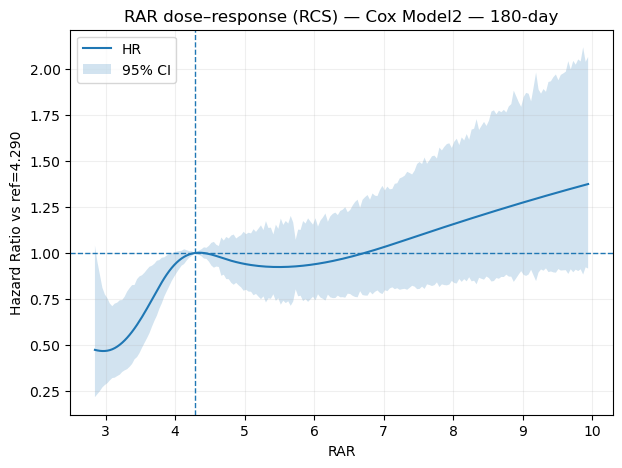

H=360: failed with penalizer=0.0 -> singular/collinear
H=360: OK with penalizer=0.0001 | N=1212 | events=509 | p=14
H=360: failed with penalizer=0.0 -> singular/collinear
H=360: OK with penalizer=0.0001 | N=1203 | events=503 | p=17

H=360d
Model1 spline penalizer=0.0001 | non-linearity LR=18.691, df=5, p=0.00219 | N=1212, events=509
Model2 spline penalizer=0.0001 | non-linearity LR=10.391, df=5, p=0.0649 | N=1203, events=503


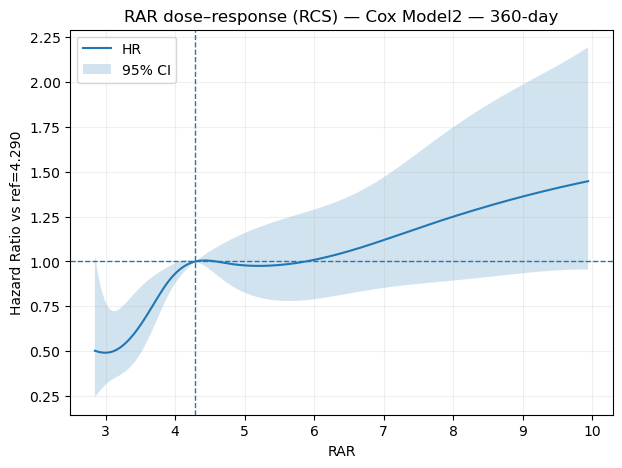

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError
from patsy import dmatrix
from scipy.stats import chi2


# -----------------------
# Helpers
# -----------------------
def rcs_knots(x, n_knots=4):
    """
    Harrell-style knot locations (percentiles).
    4 knots: 5, 35, 65, 95
    5 knots: 5, 27.5, 50, 72.5, 95
    """
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna()
    if n_knots == 3:
        qs = [0.10, 0.50, 0.90]
    elif n_knots == 4:
        qs = [0.05, 0.35, 0.65, 0.95]
    elif n_knots == 5:
        qs = [0.05, 0.275, 0.50, 0.725, 0.95]
    else:
        raise ValueError("n_knots must be 3, 4, or 5")
    return np.quantile(x, qs)


def make_rcs_basis(x, knots, prefix="RAR_rcs", lower_bound=None, upper_bound=None):
    """
    Restricted cubic spline basis via patsy: cr().
    IMPORTANT: pass the SAME lower_bound/upper_bound everywhere (fit + grid + ref),
               otherwise single-value calls (ref) will explode.
    """
    x = pd.to_numeric(pd.Series(x), errors="coerce")
    mask = x.notna() & np.isfinite(x)
    x_non = x.loc[mask].values

    if lower_bound is None:
        lower_bound = float(np.nanmin(x_non)) if len(x_non) else np.nan
    if upper_bound is None:
        upper_bound = float(np.nanmax(x_non)) if len(x_non) else np.nan

    # clip inside bounds (safety)
    x_non = np.clip(x_non, lower_bound, upper_bound)

    B_non = dmatrix(
        "0 + cr(x, knots=knots, lower_bound=lb, upper_bound=ub)",
        {"x": x_non, "knots": np.asarray(knots), "lb": lower_bound, "ub": upper_bound},
        return_type="dataframe"
    )

    colnames = [f"{prefix}{i+1}" for i in range(B_non.shape[1])]
    B_non.columns = colnames

    B_full = pd.DataFrame(np.nan, index=x.index, columns=colnames)
    B_full.loc[mask, :] = B_non.to_numpy()
    return B_full


def lr_test(ll_small, ll_big, df_diff):
    LR = 2 * (ll_big - ll_small)
    p = chi2.sf(LR, df=df_diff)
    return LR, p


def build_race_dummies(df, top_n=6):
    df = df.copy()
    df["race"] = df["race"].astype(str)
    race_top = df["race"].value_counts().head(top_n).index
    df["race_slim"] = np.where(df["race"].isin(race_top), df["race"], "Other")
    race_dummies = pd.get_dummies(df["race_slim"], prefix="race", drop_first=True)
    return df, race_dummies


def fit_cox(df_in, H, covs, penalizer=0.0, l1_ratio=0.0, verbose=False):
    """
    Returns: cph, tmp, dur, ev, covs_used
    """
    dur = f"duration_{H}d"

    if f"event_{H}d" in df_in.columns:
        ev = f"event_{H}d"
    elif f"mort_{H}d" in df_in.columns:
        ev = f"mort_{H}d"
    else:
        raise KeyError(f"Δεν βρήκα ούτε event_{H}d ούτε mort_{H}d")

    cols = [dur, ev] + list(covs)
    tmp = df_in[cols].copy()

    tmp[dur] = pd.to_numeric(tmp[dur], errors="coerce")
    tmp[ev]  = pd.to_numeric(tmp[ev], errors="coerce")
    for c in covs:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")

    tmp = tmp.dropna()

    nun = tmp[covs].nunique(dropna=False)
    const_cols = nun[nun <= 1].index.tolist()
    if const_cols and verbose:
        print("Dropping constant cols:", const_cols)

    covs2 = [c for c in covs if c not in const_cols]
    tmp = tmp[[dur, ev] + covs2]

    if len(covs2) > 0:
        var = tmp[covs2].var()
        near0 = var[var < 1e-12].index.tolist()
    else:
        near0 = []

    if near0 and verbose:
        print("Dropping near-zero variance cols:", near0)

    covs3 = [c for c in covs2 if c not in near0]
    tmp = tmp[[dur, ev] + covs3]

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph.fit(tmp, duration_col=dur, event_col=ev, show_progress=False)
    return cph, tmp, dur, ev, covs3


def fit_cox_auto(df_in, H, covs, penalizers=(0.0, 1e-4, 1e-3, 1e-2, 1e-1), verbose=True):
    last_err = None
    for pen in penalizers:
        try:
            cph, tmp, dur, ev, covs_used = fit_cox(df_in, H, covs, penalizer=pen, verbose=verbose)
            if verbose:
                print(f"H={H}: OK with penalizer={pen} | N={len(tmp)} | events={int(tmp[ev].sum())} | p={len(covs_used)}")
            return cph, tmp, dur, ev, covs_used, pen
        except ConvergenceError as e:
            last_err = e
            if verbose:
                print(f"H={H}: failed with penalizer={pen} -> singular/collinear")
    raise last_err


def plot_dose_response(
    cph,
    knots,
    base_template_row,
    spline_prefix,
    x_grid,
    lower_bound,
    upper_bound,
    ref_value=None,
    x_label="RAR",
    title=""
):
    """
    x_grid: array of x values for plotting (recommended: quantiles range of observed sample)
    lower_bound/upper_bound: MUST be the same bounds used when creating the spline basis for fitting
    """
    x_grid = np.asarray(x_grid, dtype=float)
    x_grid = np.clip(x_grid, lower_bound, upper_bound)

    if ref_value is None:
        ref_value = float(np.median(x_grid))
    ref_value = float(np.clip(ref_value, lower_bound, upper_bound))

    B_grid = make_rcs_basis(
        pd.Series(x_grid),
        knots,
        prefix=spline_prefix,
        lower_bound=lower_bound,
        upper_bound=upper_bound
    ).reset_index(drop=True)

    B_ref = make_rcs_basis(
        pd.Series([ref_value]),
        knots,
        prefix=spline_prefix,
        lower_bound=lower_bound,
        upper_bound=upper_bound
    ).reset_index(drop=True)

    X = pd.concat([pd.concat([base_template_row] * len(x_grid), ignore_index=True), B_grid], axis=1)
    X_ref = pd.concat([base_template_row.reset_index(drop=True), B_ref], axis=1)

    cols = list(cph.params_.index)
    X = X[cols]
    X_ref = X_ref[cols].iloc[0].values.reshape(1, -1)

    beta = cph.params_.values.reshape(-1, 1)
    V = cph.variance_matrix_.values

    D = X.values - X_ref
    lp_diff = (D @ beta).flatten()
    se = np.sqrt(np.einsum("ij,jk,ik->i", D, V, D))

    hr = np.exp(lp_diff)
    lo_ci = np.exp(lp_diff - 1.96 * se)
    hi_ci = np.exp(lp_diff + 1.96 * se)

    plt.figure(figsize=(7, 5))
    plt.plot(x_grid, hr, label="HR")
    plt.fill_between(x_grid, lo_ci, hi_ci, alpha=0.2, label="95% CI")
    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.axvline(ref_value, linestyle="--", linewidth=1)
    plt.xlabel(x_label)
    plt.ylabel(f"Hazard Ratio vs ref={ref_value:.3f}")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()


# -----------------------
# MAIN: RAR RCS Cox
# -----------------------
df = df.copy()
df["gender_M"] = (df["gender"] == "M").astype(int)
df["RAR"] = pd.to_numeric(df["RAR"], errors="coerce")

df, race_dummies = build_race_dummies(df, top_n=6)
race_cols = list(race_dummies.columns)

df_r = pd.concat([df, race_dummies], axis=1)

# knots from all available RAR (non-missing)
knots = rcs_knots(df_r["RAR"], n_knots=4)
print("RCS knots:", knots)

# GLOBAL bounds for spline basis (critical!)
rar_all = pd.to_numeric(df_r["RAR"], errors="coerce")
rar_all = rar_all[np.isfinite(rar_all)]
RAR_LB = float(rar_all.min())
RAR_UB = float(rar_all.max())

# spline basis for dataset with fixed bounds
B = make_rcs_basis(df_r["RAR"], knots, prefix="RAR_rcs", lower_bound=RAR_LB, upper_bound=RAR_UB)
df_r = pd.concat([df_r, B], axis=1)
spline_cols = list(B.columns)

# covariates
base_cols = ["age", "gender_M", "sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

model1_covs_rcs = ["age", "gender_M"] + race_cols + spline_cols
model2_covs_rcs = model1_covs_rcs + ["sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

model1_covs_lin = ["age", "gender_M"] + race_cols + ["RAR"]
model2_covs_lin = model1_covs_lin + ["sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

H_list = [30, 180, 360]

for H in H_list:
    # spline Cox
    cph1_s, tmp1_s, dur, ev, covs1_used, pen1 = fit_cox_auto(df_r, H, model1_covs_rcs, verbose=True)
    cph2_s, tmp2_s, dur, ev, covs2_used, pen2 = fit_cox_auto(df_r, H, model2_covs_rcs, verbose=True)

    # linear Cox (for LR test)
    cph1_l, tmp1_l, dur, ev, covs1_lin_used = fit_cox(df_r, H, model1_covs_lin, penalizer=0.0, verbose=False)
    cph2_l, tmp2_l, dur, ev, covs2_lin_used = fit_cox(df_r, H, model2_covs_lin, penalizer=0.0, verbose=False)

    # LR test: spline vs linear
    df_diff1 = sum(c.startswith("RAR_rcs") for c in covs1_used) - 1
    df_diff2 = sum(c.startswith("RAR_rcs") for c in covs2_used) - 1

    LR1, p1 = lr_test(cph1_l.log_likelihood_, cph1_s.log_likelihood_, df_diff1)
    LR2, p2 = lr_test(cph2_l.log_likelihood_, cph2_s.log_likelihood_, df_diff2)

    print(f"\nH={H}d")
    print(f"Model1 spline penalizer={pen1} | non-linearity LR={LR1:.3f}, df={df_diff1}, p={p1:.3g} | N={len(tmp1_s)}, events={int(tmp1_s[ev].sum())}")
    print(f"Model2 spline penalizer={pen2} | non-linearity LR={LR2:.3f}, df={df_diff2}, p={p2:.3g} | N={len(tmp2_s)}, events={int(tmp2_s[ev].sum())}")

    # plotting sample (use same rows as tmp2_s)
    rar_used = pd.to_numeric(df_r.loc[tmp2_s.index, "RAR"], errors="coerce")
    rar_used = rar_used[np.isfinite(rar_used)]

    ref_rar = float(rar_used.median())

    # grid = 1%..99% of used sample (recommended)
    qlo, qhi = rar_used.quantile([0.01, 0.99]).values
    x_grid = np.linspace(float(qlo), float(qhi), 200)

    # base template to match model params
    non_spline_cols = [c for c in cph2_s.params_.index if not c.startswith("RAR_rcs")]

    row = {}
    for c in non_spline_cols:
        if c.startswith("race_"):
            row[c] = 0.0
        elif c == "gender_M":
            row[c] = 0.0  # βάλε 1.0 αν θες άνδρα
        else:
            row[c] = float(tmp2_s[c].mean())

    base_template = pd.DataFrame([row])

    plot_dose_response(
        cph2_s,
        knots=knots,
        base_template_row=base_template,
        spline_prefix="RAR_rcs",
        x_grid=x_grid,
        lower_bound=RAR_LB,
        upper_bound=RAR_UB,
        ref_value=ref_rar,
        x_label="RAR",
        title=f"RAR dose–response (RCS) — Cox Model2 — {H}-day"
    )
